# Моделирование параметрического излучения

Класс резонатора

In [18]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:


import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import complex_ode, solve_ivp
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
from scipy.constants import pi, c, hbar
from matplotlib.widgets import Slider, Button, TextBox
from matplotlib.animation import FuncAnimation
import matplotlib.image as mpimg
from scipy.optimize import curve_fit, root
import time
import torch
from scipy.sparse import block_diag, identity, diags
import scipy.integrate as integrate
from scipy.optimize import fsolve
from tqdm import tqdm as tqdm


class Resonator:
    def __init__(self, resonator_parameters):
        #Initialization of physical parameters
        self.n0=resonator_parameters['n0']
        self.n2=resonator_parameters['n2']
        self.FSR=resonator_parameters['FSR']
        self.w0=resonator_parameters['w0']
        self.width=resonator_parameters['width']
        self.height=resonator_parameters['height']
        self.kappa_0=resonator_parameters['kappa_0']
        self.kappa_ex=resonator_parameters['kappa_ex']
        self.Dint=np.fft.ifftshift(resonator_parameters['Dint'])
        self.n=resonator_parameters['n_pump']
        #Auxiliary physical parameters
        self.Tr=1/self.FSR
        self.Aeff=self.width*self.height
        self.Leff=c/self.n0*self.Tr
        self.Veff=self.Aeff*self.Leff
        self.g0=hbar*self.w0**2*c*self.n2/self.n0**2/self.Veff
        self.gamma=self.n2*self.w0/c/self.Aeff
        self.kappa=self.kappa_0+self.kappa_ex
        self.r_theta=resonator_parameters['thermal_Kerr']
        self.k_theta=resonator_parameters['thermal_time']*self.kappa
        self.N_points=len(self.Dint)
        mu=np.fft.fftshift(np.arange(-self.N_points/2, self.N_points/2))
        self.mu=np.fft.fftshift(np.arange(-self.N_points/2, self.N_points/2))
        def func(x, a, b, c, d):
            return a+x*b+c*x**2/2+d*x**3/6
        popt, pcov=curve_fit(func, mu, self.Dint)
        self.D2=popt[2]
        self.D3=popt[3]
        self.N_micro=resonator_parameters['N_micro']
        self.attempt_num=resonator_parameters['attempt_num']
        self.dzeta=resonator_parameters['dzeta']*2/self.kappa
        self.seed_coup=np.zeros((self.attempt_num, self.N_micro, np.shape(mu)[0]), dtype=np.complex128)
        self.seed_theta=np.zeros((self.attempt_num, self.N_micro), dtype=np.double)
        self.pump_coup=np.zeros_like(self.seed_coup, dtype=np.complex128)
        
        self.seed_coup_single=np.zeros((np.shape(mu)[0]), dtype=np.complex128)
        self.pump_coup_single=np.zeros_like(self.seed_coup_single, dtype=np.complex128)
        self.alpha=resonator_parameters['alpha']
        self.beta=resonator_parameters['beta']
        self.beta_star=np.conjugate(self.beta)
    ### Noise initialisation
    def noise(self, a):
        return a*(2*np.random.rand(self.attempt_num, self.N_micro, self.N_points)-1+1j*(2*np.random.rand(self.attempt_num, self.N_micro, self.N_points)-1))
    
    
    
    def Propagate_SplitStep_dual(self, simulation_parameters, Pump,   Seed=[0], dt=1e-3):
        ### Initialisation parameters for solver
        start_time=time.time()
        T=simulation_parameters['slow_time']
        out_param=simulation_parameters['output']
        detuning1=simulation_parameters['detuning_array1']
        detuning2=simulation_parameters['detuning_array2']
        eps=simulation_parameters['noise_level']

        pump_c=self.pump_coup
        seed_c=self.seed_coup
        seed_c_back=self.seed_coup.copy()
        pump_c[:,:]=Pump*np.sqrt(1./(hbar*self.w0))

        if Seed == [0]:
            seed_c[:,:] = self.seed_level_two_pumps(Pump, detuning1[0], detuning2[0])
            #seed_c[:,:],  seed_c_back[:,:] = self.seed_level_two_pumps_back(Pump, detuning1[0], detuning2[0])
        else:
            seed_c[:,:] = Seed
            #seed_c_back[:,:] = Seed
        ### Renormalization
        T_rn=(self.kappa/2)*T
        f0=pump_c*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        noise_const=self.noise(eps)
        nn=len(detuning1)
        random_attempt=np.random.randint(self.attempt_num)
        t_st=float(T_rn)/len(detuning1)


        sol=np.ndarray(shape=(self.attempt_num, self.N_micro,  self.N_points), dtype='complex128') #define an array to store the data
        sol_eval=np.ndarray(shape=(len(detuning1), self.N_micro,  self.N_points), dtype='complex128') #define an array to store the data
        #sol_back=np.ndarray(shape=(self.attempt_num, self.N_micro,  self.N_points), dtype='complex128')
        #sol_back_eval=np.ndarray(shape=(len(detuning1), self.N_micro,  self.N_points), dtype='complex128')
        sol[:,:,:]=(seed_c)
        #sol_back[:,:,:]=(seed_c_back)

        #print(sol[0,0,:])
        #print(sol_back[0,0,:])
        

        
        ##Calculate effective detuning (zeta in our texts)
        num_det=np.arange(len(detuning1))
        dOm_curr=-(detuning1[num_det]+detuning2[num_det]).reshape(-1,1)/2-(detuning1[num_det]-detuning2[num_det]).reshape(-1,1)/2/self.n*self.mu+self.Dint #detuning value
        
        ### Initial values of amplitudes
        buf=sol.copy()
        #buf_back=sol_back.copy()
        sol_eval[0]=sol[random_attempt]
        #sol_back_eval[0]=sol_back[random_attempt]
        length=len(buf[0,0,:]) ### Number of considered modes in our model        
        K_for=-(1 + 1j * dOm_curr * 2/self.kappa)
        #K_back=-(1+1j*dOm_curr*2/self.kappa)
        #dOm_curr_exp=np.exp(-dt*(1+1j*dOm_curr*2/self.kappa)) #The coefficient in the second solver step
        pumping=f0*length
        #backscattering_coeff=1j*self.beta
        #forw_back_coup=2j*self.alpha
        ### Transform pumps into the time-domain (multiplication by length (N) is necessary to compensate the coefficient from FFT  in first step of solver)
        f=np.fft.ifft(f0,axis=2)*length 
        
        #Start to solve
        for it in tqdm(range(1, len(detuning1))):
            t=0
            buf=sol-noise_const
            #if it==1:
                #continue
            #buf_back=sol_back-noise_const
            #else:
            #    buf_back=sol_back-noise_const
            exp_forward=np.exp(dt * K_for[it])
            
            total_pumping = pumping * (exp_forward - 1) / K_for[it]
#             buf=(pumping+backscattering_coeff*buf_dir_back)*(exp_forward-1)/K_forward + exp_forward*buf_dir

            while t<t_st:
                # First step
                ### Transform amplitudes into the direct-space
                buf_dir=np.fft.ifft(buf, axis=2)
                #buf_dir_back=np.fft.ifft(buf_back, axis=2)

                # Calculation of the first step of solver and transformation back into the frequency-space
                ### IMPORTANT Due to Numpy FFT and IFFT formulation the final value will be multiplied by the coefficient "length" which is the number of modes N in our model.
                # The final solution is Num_of_modes*a. Don't forget divide into the number of modes after solving.
               
                buf_dir=np.fft.fft(np.exp(dt*(1j*np.abs(buf_dir)**2))*buf_dir, axis=2)
                #buf_dir_back=np.fft.fft(np.exp(dt*(1j*np.abs(buf_dir_back)**2))*buf_dir_back, axis=2)
                
                # Second step
                ### Calculate the second step of split-step method
                #K_backward=forw_back_coup*np.sum(np.abs(buf_dir/length)**2, axis=2)+K_back[it]
                #exp_backward=np.exp(dt*K_backward)
                buf = total_pumping + exp_forward * buf_dir
                #buf_back=(backscattering_coeff*buf_dir)*(exp_backward-1)/K_backward+exp_backward*buf_dir_back                                             
                                                       
                                                     
                t+=dt
                
            sol=buf.copy() ### Current step of all attempts
            sol_eval[it]=sol[random_attempt] ### Time-evolution of one attempt
            #sol_back=buf_back.copy()
            #sol_back_eval[it]=sol_back[random_attempt]
        ### Final solutions
        ### Here we don't forget to divide the solution by the number of modes  (length)!!!
        if out_param=='map':
            return sol/length, sol_eval/length,  detuning1, detuning2 
        elif out_param=='fin_res':
            return sol[-1,:]/length
        else: 
            print('wrong parameter')
            
    def Propagate_SplitStep_dual_single_ring(self, simulation_parameters, Pump,   Seed=[0], dt=1e-3):
        ### Initialisation parameters for solver
        start_time=time.time()
        T=simulation_parameters['slow_time']
        out_param=simulation_parameters['output']
        detuning1=simulation_parameters['detuning_array1']
        detuning2=simulation_parameters['detuning_array2']
        eps = simulation_parameters['noise_level']

        pump_c = self.pump_coup_single
        seed_c = self.seed_coup_single
        pump_c= Pump * np.sqrt(1. / (hbar * self.w0))

        if Seed == [0]:
            seed_c = self.seed_level_two_pumps(Pump, detuning1[0], detuning2[0])
        else:
            seed_c = Seed
            #seed_c_back[:,:] = Seed
        ### Renormalization
        T_rn=(self.kappa/2)*T
        f0=pump_c*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        noise_const=self.noise(eps)
        nn=len(detuning1)
        random_attempt=np.random.randint(self.attempt_num)
        t_st=float(T_rn)/len(detuning1)


        sol = np.ndarray(shape = (self.N_points), dtype='complex128') #define an array to store the 
        sol_eval = np.ndarray(shape = (len(detuning1), self.N_points), dtype='complex128') #define an array to store 
        sol[:] = (seed_c)

        
        ##Calculate effective detuning (zeta in our texts)
        num_det = np.arange(len(detuning1))
        dOm_curr = - (detuning1[num_det] + detuning2[num_det]).reshape(-1,1) / 2 - (detuning1[num_det] - detuning2[num_det]).reshape(-1,1) / 2 / self.n * self.mu + self.Dint #detuning value
        
        ### Initial values of amplitudes
        buf = sol.copy()
        #buf_back=sol_back.copy()
        #sol_eval[0]=sol[random_attempt]
        #sol_back_eval[0]=sol_back[random_attempt]
        length = len(buf) ### Number of considered modes in our model        
        K_for = - (1 + 1j * dOm_curr * 2 / self.kappa)
        #K_back=-(1+1j*dOm_curr*2/self.kappa)
        #dOm_curr_exp=np.exp(-dt*(1+1j*dOm_curr*2/self.kappa)) #The coefficient in the second solver step
        pumping = f0 * length
        #backscattering_coeff=1j*self.beta
        #forw_back_coup=2j*self.alpha
        ### Transform pumps into the time-domain (multiplication by length (N) is necessary to compensate the coefficient from FFT  in first step of solver)
        f = np.fft.ifft(f0) * length 
        
        #Start to solve
        for it in tqdm(range(1, len(detuning1))):
            t = 0
            buf = sol - noise_const
            #if it==1:
                #continue
            #buf_back=sol_back-noise_const
            #else:
            #    buf_back=sol_back-noise_const
            exp_forward = np.exp(dt * K_for[it])
            
            total_pumping = pumping * (exp_forward - 1) / K_for[it]
#             buf=(pumping+backscattering_coeff*buf_dir_back)*(exp_forward-1)/K_forward + exp_forward*buf_dir

            while t < t_st:
                # First step
                ### Transform amplitudes into the direct-space
                buf_dir = np.fft.ifft(buf)
                #buf_dir_back=np.fft.ifft(buf_back, axis=2)

                # Calculation of the first step of solver and transformation back into the frequency-space
                ### IMPORTANT Due to Numpy FFT and IFFT formulation the final value will be multiplied by the coefficient "length" which is the number of modes N in our model.
                # The final solution is Num_of_modes*a. Don't forget divide into the number of modes after solving.
               
                buf_dir = np.fft.fft(np.exp(dt * 1j * np.abs(buf_dir) ** 2) * buf_dir)
                
                #buf_dir_back=np.fft.fft(np.exp(dt*(1j*np.abs(buf_dir_back)**2))*buf_dir_back, axis=2)
                
                # Second step
                ### Calculate the second step of split-step method
                #K_backward=forw_back_coup*np.sum(np.abs(buf_dir/length)**2, axis=2)+K_back[it]
                #exp_backward=np.exp(dt*K_backward)
                buf = total_pumping + exp_forward * buf_dir
                #buf_back=(backscattering_coeff*buf_dir)*(exp_backward-1)/K_backward+exp_backward*buf_dir_back                                             
                                                       
                                                     
                t += dt
                
            sol=buf.copy() ### Current step of all attempts
            sol_eval[it]=sol ### Time-evolution of one attempt
            #sol_back=buf_back.copy()
            #sol_back_eval[it]=sol_back[random_attempt]
        ### Final solutions
        ### Here we don't forget to divide the solution by the number of modes  (length)!!!
        if out_param=='map':
            return sol/length, sol_eval/length,  detuning1, detuning2 
        elif out_param=='fin_res':
            return sol[-1,:]/length
        else: 
            print('wrong parameter')
                    
    def Propagate_SplitStep_dual_single_ring_v1(self, simulation_parameters, Pump,   Seed=[0], dt = 1e-3):
        ### Initialisation parameters for solver
        start_time=time.time()
        T=simulation_parameters['slow_time']
        out_param=simulation_parameters['output']
        detuning1=simulation_parameters['detuning_array1']
        detuning2=simulation_parameters['detuning_array2']
        eps = simulation_parameters['noise_level']

        pump_c = self.pump_coup_single
        seed_c = self.seed_coup_single
        pump_c = Pump * np.sqrt(1. / (hbar * self.w0))

        if Seed == [0]:
            seed_c = self.seed_level_two_pumps(Pump, detuning1[0], detuning2[0])
        else:
            seed_c = Seed
            #seed_c_back[:,:] = Seed
        ### Renormalization
        T_rn=(self.kappa/2)*T
        f0=pump_c*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        noise_const=self.noise(eps)
        nn=len(detuning1)
        random_attempt=np.random.randint(self.attempt_num)
        t_st=float(T_rn)/len(detuning1)


        sol = np.ndarray(shape = (self.N_points), dtype='complex128') #define an array to store the 
        sol_eval = np.ndarray(shape = (len(detuning1), self.N_points), dtype='complex128') #define an array to store 
        sol[:] = (seed_c)

        
        ##Calculate effective detuning (zeta in our texts)
        num_det = np.arange(len(detuning1))
        dOm_curr = - (detuning1[num_det] + detuning2[num_det]).reshape(-1,1) / 2 - (detuning1[num_det] - detuning2[num_det]).reshape(-1,1) / 2 / self.n * self.mu + self.Dint #detuning value
        
        ### Initial values of amplitudes
        buf = sol.copy()
        #buf_back=sol_back.copy()
        #sol_eval[0]=sol[random_attempt]
        #sol_back_eval[0]=sol_back[random_attempt]
        length = len(buf) ### Number of considered modes in our model        
        K_for = - (1 + 1j * dOm_curr * 2 / self.kappa)
        #K_back=-(1+1j*dOm_curr*2/self.kappa)
        #dOm_curr_exp=np.exp(-dt*(1+1j*dOm_curr*2/self.kappa)) #The coefficient in the second solver step
        pumping = f0 * length
        #backscattering_coeff=1j*self.beta
        #forw_back_coup=2j*self.alpha
        ### Transform pumps into the time-domain (multiplication by length (N) is necessary to compensate the coefficient from FFT  in first step of solver)
        f = np.fft.ifft(f0) * length 
        
        #Start to solve
        for it in tqdm(range(1, len(detuning1))):
            t = 0
            buf = sol - noise_const
            #if it==1:
                #continue
            #buf_back=sol_back-noise_const
            #else:
            #    buf_back=sol_back-noise_const
            #exp_forward = np.exp(dt * K_for[it])
            exp_forward = np.exp(dt * K_for[it])

            #total_pumping = pumping * (exp_forward - 1) / K_for[it]
#             buf=(pumping+backscattering_coeff*buf_dir_back)*(exp_forward-1)/K_forward + exp_forward*buf_dir

            while t < t_st:
                # First step
                ### Transform amplitudes into the direct-space
                
                buf_dir = np.fft.ifft(buf)
                #buf_dir_back=np.fft.ifft(buf_back, axis=2)

                # Calculation of the first step of solver and transformation back into the frequency-space
                ### IMPORTANT Due to Numpy FFT and IFFT formulation the final value will be multiplied by the coefficient "length" which is the number of modes N in our model.
                # The final solution is Num_of_modes*a. Don't forget divide into the number of modes after solving.
                buf_dir=np.fft.fft(np.exp(dt*(1j*np.abs(buf_dir)**2+f/buf_dir))*buf_dir)

                #buf_dir = np.fft.fft(np.exp(dt * 1j * np.abs(buf_dir) ** 2) * buf_dir)
                
                #buf_dir_back=np.fft.fft(np.exp(dt*(1j*np.abs(buf_dir_back)**2))*buf_dir_back, axis=2)
                
                # Second step
                ### Calculate the second step of split-step method
                #K_backward=forw_back_coup*np.sum(np.abs(buf_dir/length)**2, axis=2)+K_back[it]
                #exp_backward=np.exp(dt*K_backward)
    #                 buf = total_pumping + exp_forward * buf_dir
                buf=exp_forward*buf_dir

                #buf_back=(backscattering_coeff*buf_dir)*(exp_backward-1)/K_backward+exp_backward*buf_dir_back                                             
                                                       
                                                     
                t += dt
                
            sol=buf.copy() ### Current step of all attempts
            sol_eval[it]=sol ### Time-evolution of one attempt
            #sol_back=buf_back.copy()
            #sol_back_eval[it]=sol_back[random_attempt]
        ### Final solutions
        ### Here we don't forget to divide the solution by the number of modes  (length)!!!
        if out_param=='map':
            return sol/length, sol_eval/length,  detuning1, detuning2 
        elif out_param=='fin_res':
            return sol[-1,:]/length
        else: 
            print('wrong parameter')
            
            
            
    def Propagate_SplitStep_dual_back(self, simulation_parameters, Pump,   Seed=[0], dt=1e-3):
        ### Initialisation parameters for solver
        start_time=time.time()
        T=simulation_parameters['slow_time']
        out_param=simulation_parameters['output']
        detuning1=simulation_parameters['detuning_array1']
        detuning2=simulation_parameters['detuning_array2']
        eps=simulation_parameters['noise_level']

        pump_c=self.pump_coup
        seed_c=self.seed_coup
        seed_c_back=self.seed_coup.copy()
        pump_c[:,:]=Pump*np.sqrt(1./(hbar*self.w0))

        if Seed == [0]:
            #seed_c[:,:],  seed_c_back[:,:] = self.seed_level_two_pumps_SIL(Pump, detuning1[0], detuning2[0])
            seed_c[:,:],  seed_c_back[:,:] = self.seed_level_two_pumps_back(Pump, detuning1[0], detuning2[0])
        else:
            seed_c[:,:] = Seed
            seed_c_back[:,:] = Seed
        ### Renormalization
        T_rn=(self.kappa/2)*T
        f0=pump_c*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        noise_const=self.noise(eps)
        nn=len(detuning1)
        random_attempt=np.random.randint(self.attempt_num)
        t_st=float(T_rn)/len(detuning1)


        sol=np.ndarray(shape=(self.attempt_num, self.N_micro,  self.N_points), dtype='complex128') #define an array to store the data
        sol_eval=np.ndarray(shape=(len(detuning1), self.N_micro,  self.N_points), dtype='complex128') #define an array to store the data
        sol_back=np.ndarray(shape=(self.attempt_num, self.N_micro,  self.N_points), dtype='complex128')
        sol_back_eval=np.ndarray(shape=(len(detuning1), self.N_micro,  self.N_points), dtype='complex128')
        sol[:,:,:]=(seed_c)
        sol_back[:,:,:]=(seed_c_back)

        #print(sol[0,0,:])
        #print(sol_back[0,0,:])
        

        
        ##Calculate effective detuning (zeta in our texts)
        num_det=np.arange(len(detuning1))
        dOm_curr=-(detuning1[num_det]+detuning2[num_det]).reshape(-1,1)/2-(detuning1[num_det]-detuning2[num_det]).reshape(-1,1)/2/self.n*self.mu+self.Dint #detuning value
        
        ### Initial values of amplitudes
        buf=sol.copy()
        buf_back=sol_back.copy()
        sol_eval[0]=sol[random_attempt]
        sol_back_eval[0]=sol_back[random_attempt]
        length=len(buf[0,0,:]) ### Number of considered modes in our model        
        K_for=-(1+1j*dOm_curr*2/self.kappa)
        K_back=-(1+1j*dOm_curr*2/self.kappa)
        #dOm_curr_exp=np.exp(-dt*(1+1j*dOm_curr*2/self.kappa)) #The coefficient in the second solver step
        pumping=f0*length
        backscattering_coeff=1j*self.beta
        forw_back_coup=2j*self.alpha
        ### Transform pumps into the time-domain (multiplication by length (N) is necessary to compensate the coefficient from FFT  in first step of solver)
        f=np.fft.ifft(f0,axis=2)*length 
        
        #Start to solve
        for it in tqdm(range(1, len(detuning1))):
            t=0
            buf=sol-noise_const
            #if it==1:
                #continue
            buf_back=sol_back-noise_const
            #else:
            #    buf_back=sol_back-noise_const
            while t<t_st:
                # First step
                ### Transform amplitudes into the direct-space
                buf_dir=np.fft.ifft(buf, axis=2)
                buf_dir_back=np.fft.ifft(buf_back, axis=2)

                # Calculation of the first step of solver and transformation back into the frequency-space
                ### IMPORTANT Due to Numpy FFT and IFFT formulation the final value will be multiplied by the coefficient "length" which is the number of modes N in our model.
                # The final solution is Num_of_modes*a. Don't forget divide into the number of modes after solving.
               
                buf_dir=np.fft.fft(np.exp(dt*(1j*np.abs(buf_dir)**2))*buf_dir, axis=2)
                buf_dir_back=np.fft.fft(np.exp(dt*(1j*np.abs(buf_dir_back)**2))*buf_dir_back, axis=2)
                
                # Second step
                ### Calculate the second step of split-step method
                K_forward=forw_back_coup*np.sum(np.abs(buf_dir_back/length)**2, axis=2)+K_for[it]
                K_backward=forw_back_coup*np.sum(np.abs(buf_dir/length)**2, axis=2)+K_back[it]
                exp_forward=np.exp(dt*K_forward)
                exp_backward=np.exp(dt*K_backward)
                buf=(pumping+backscattering_coeff*buf_dir_back)*(exp_forward-1)/K_forward+exp_forward*buf_dir
                buf_back=(backscattering_coeff*buf_dir)*(exp_backward-1)/K_backward+exp_backward*buf_dir_back                                             
                                                       
                                                     
                t+=dt
                
            sol=buf.copy() ### Current step of all attempts
            sol_eval[it]=sol[random_attempt] ### Time-evolution of one attempt
            sol_back=buf_back.copy()
            sol_back_eval[it]=sol_back[random_attempt]
        ### Final solutions
        ### Here we don't forget to divide the solution by the number of modes  (length)!!!
        if out_param=='map':
            return sol/length, sol_eval/length,sol_back/length, sol_back_eval/length, detuning1, detuning2 
        elif out_param=='fin_res':
            return sol[-1,:]/length
        else: 
            print('wrong parameter')
            
            
            
            

   
            
            
            
    def Propagate_SplitStep_dual_back_thermal(self, simulation_parameters, Pump,   Seed=[0], dt=1e-3):
        ### Initialisation parameters for solver
        start_time=time.time()
        T=simulation_parameters['slow_time']
        out_param=simulation_parameters['output']
        detuning1=simulation_parameters['detuning_array1']
        detuning2=simulation_parameters['detuning_array2']
        eps=simulation_parameters['noise_level']

        pump_c=self.pump_coup
        seed_c=self.seed_coup
        seed_c_back=self.seed_coup.copy()
        seed_c_theta=self.seed_theta.copy()
        pump_c[:,:]=Pump*np.sqrt(1./(hbar*self.w0))

        if Seed == [0]:
            seed_c[:,:],  seed_c_back[:,:], seed_c_theta[:,:] = self.seed_level_two_pumps_SIL_thermal(Pump, detuning1[0], detuning2[0])
            #seed_c[:,:],  seed_c_back[:,:], seed_c_theta[:,:] = self.seed_level_two_pumps_back_thermal(Pump, detuning1[0], detuning2[0])
        else:
            seed_c[:,:] = Seed
            seed_c_back[:,:] = Seed
            seed_c_theta[:,:]= Seed
        ### Renormalization
        T_rn=(self.kappa/2)*T
        f0=pump_c*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        noise_const=self.noise(eps)
        nn=len(detuning1)
        random_attempt=np.random.randint(self.attempt_num)
        t_st=float(T_rn)/len(detuning1)


        sol=np.ndarray(shape=(self.attempt_num, self.N_micro,  self.N_points), dtype='complex128') #define an array to store the data
        sol_eval=np.ndarray(shape=(len(detuning1), self.N_micro,  self.N_points), dtype='complex128') #define an array to store the data
        sol_back=np.ndarray(shape=(self.attempt_num, self.N_micro,  self.N_points), dtype='complex128')
        sol_back_eval=np.ndarray(shape=(len(detuning1), self.N_micro,  self.N_points), dtype='complex128')
        sol_theta=np.ndarray(shape=(self.attempt_num, self.N_micro), dtype='double')
        sol_theta_eval=np.ndarray(shape=(len(detuning1), self.N_micro), dtype='double')
        sol[:,:,:]=(seed_c)
        sol_back[:,:,:]=(seed_c_back)
        sol_theta[:,:]=(seed_c_theta)

        print(sol[0,0,:])
        print(sol_back[0,0])
        print(sol_theta[0,0])
        



        ##Calculate effective detuning (zeta in our texts)
        num_det=np.arange(len(detuning1))
        dOm_curr=-(detuning1[num_det]+detuning2[num_det]).reshape(-1,1)/2-(detuning1[num_det]-detuning2[num_det]).reshape(-1,1)/2/self.n*self.mu+self.Dint #detuning value

        ### Initial values of amplitudes
        buf=sol.copy()
        buf_back=sol_back.copy()
        theta=sol_theta.copy()
        sol_eval[0]=sol[random_attempt]
        sol_back_eval[0]=sol_back[random_attempt]
        sol_theta_eval[0]=sol_theta[random_attempt]
        length=len(buf[0,0,:]) ### Number of considered modes in our model        
        K_for=-(1+1j*dOm_curr*2/self.kappa)
        K_back=-(1+1j*dOm_curr*2/self.kappa)
        K_theta=-self.k_theta/self.kappa
        #dOm_curr_exp=np.exp(-dt*(1+1j*dOm_curr*2/self.kappa)) #The coefficient in the second solver step
        pumping=f0*length
        backscattering_coeff=1j*self.beta
        forw_back_coup=2j*self.alpha
        ### Transform pumps into the time-domain (multiplication by length (N) is necessary to compensate the coefficient from FFT  in first step of solver)
        f=np.fft.ifft(f0,axis=2)*length 

        #Start to solve
        for it in tqdm(range(1, len(detuning1))):
            t=0
            buf=sol-noise_const
            #if it==1:
                #continue
            buf_back=sol_back-noise_const
            #else:
            #    buf_back=sol_back-noise_const
            while t<t_st:
                # First step
                ### Transform amplitudes into the direct-space
                buf_dir=np.fft.ifft(buf, axis=2)
                buf_dir_back=np.fft.ifft(buf_back, axis=2)

                # Calculation of the first step of solver and transformation back into the frequency-space
                ### IMPORTANT Due to Numpy FFT and IFFT formulation the final value will be multiplied by the coefficient "length" which is the number of modes N in our model.
                # The final solution is Num_of_modes*a. Don't forget divide into the number of modes after solving.

                buf_dir=np.fft.fft(np.exp(dt*(1j*np.abs(buf_dir)**2))*buf_dir, axis=2)
                buf_dir_back=np.fft.fft(np.exp(dt*(1j*np.abs(buf_dir_back)**2))*buf_dir_back, axis=2)

                # Second step
                ### Calculate the second step of split-step method
                K_forward=forw_back_coup*np.sum(np.abs(buf_dir_back/length)**2, axis=2)+K_for[it]+1j*theta
                K_backward=forw_back_coup*np.sum(np.abs(buf_dir/length)**2, axis=2)+K_back[it]+1j*theta
                exp_forward=np.exp(dt*K_forward)
                exp_backward=np.exp(dt*K_backward)
                
                A_theta=(-K_theta)*self.r_theta*(np.sum(np.abs(buf_dir/length)**2+np.abs(buf_dir_back/length)**2, axis=2))
                exp_theta=np.exp(dt*K_theta)
                
                theta=A_theta*(exp_theta-1)/K_theta+exp_theta*theta

                buf=(pumping+backscattering_coeff*buf_dir_back)*(exp_forward-1)/K_forward+exp_forward*buf_dir
                buf_back=(backscattering_coeff*buf_dir)*(exp_backward-1)/K_backward+exp_backward*buf_dir_back                                             


                t+=dt

            sol=buf.copy() ### Current step of all attempts
            sol_eval[it]=sol[random_attempt] ### Time-evolution of one attempt
            sol_back=buf_back.copy()
            sol_back_eval[it]=sol_back[random_attempt]
            sol_theta_eval[it]=theta[random_attempt]
        ### Final solutions
        ### Here we don't forget to divide the solution by the number of modes  (length)!!!
        if out_param=='map':
            return sol/length, sol_eval/length,sol_back/length, sol_back_eval/length, detuning1, detuning2,theta, sol_theta_eval
        elif out_param=='fin_res':
            return sol[-1,:]/length
        else: 
            print('wrong parameter')    
            
            
            

    def seed_level_two_pumps(self,pump, detuning1, detuning2):
        f_norm=np.real(pump)*np.sqrt(1./(hbar*self.w0))*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        detuning_1_norm=2/self.kappa*(-detuning1)
        detuning_2_norm=2/self.kappa*(-detuning2)
        def myFunction(z):
            x_p = z[0]
            p_p = z[1]
            x_m = z[2]
            p_m = z[3]


            F = np.empty((4))
            F[0] = x_p-detuning_1_norm*p_p+(x_p**2+p_p**2+2*(x_m**2+p_m**2))*p_p-f_norm[self.n]
            F[1] = p_p+x_p*detuning_1_norm-(x_p**2+p_p**2+2*(x_m**2+p_m**2))*x_p
            F[2] = x_m-detuning_2_norm*p_m+(x_m**2+p_m**2+2*(x_p**2+p_p**2))*p_m-f_norm[-self.n]
            F[3] = p_m+x_m*detuning_2_norm-(x_m**2+p_m**2+2*(x_p**2+p_p**2))*x_m
            return F

        zGuess = np.array([0,0,0,0])
        sol_init=fsolve(myFunction,zGuess)
        res_seed=np.zeros_like(f_norm, dtype='complex128')
        res_seed[self.n]=(sol_init[0]+1j*sol_init[1])
        res_seed[-self.n]=(sol_init[2]+1j*sol_init[3])
        return res_seed
    
    
    
    def seed_level_two_pumps_back(self,pump, detuning1, detuning2):
        f_norm=np.real(pump)*np.sqrt(1./(hbar*self.w0))*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        detuning_1_norm=2/self.kappa*(-detuning1)
        detuning_2_norm=2/self.kappa*(-detuning2)
        def func(x):
            return [-x[0] - 1.j*detuning_1_norm*x[0] + 1.j*(2*np.abs(x[1])**2+np.abs(x[0])**2+2*self.alpha*(np.abs(x[2])**2+np.abs(x[3])**2))*x[0]+f_norm[self.n]+1.j*self.beta*x[2],
                    
                    -x[1] - 1.j*detuning_2_norm*x[1] + 1.j*(2*np.abs(x[0])**2+np.abs(x[1])**2+2*self.alpha*(np.abs(x[2])**2+np.abs(x[3])**2))*x[1]+f_norm[-self.n]+1.j*self.beta*x[3],
                    
                    -x[2] - 1.j*detuning_1_norm*x[2] + 1.j*(2*np.abs(x[3])**2+np.abs(x[2])**2+2*self.alpha*(np.abs(x[0])**2+np.abs(x[1])**2))*x[2]+1.j*self.beta*x[0],
                    
                    -x[3] - 1.j*detuning_2_norm*x[3] + 1.j*(2*np.abs(x[2])**2+np.abs(x[3])**2+2*self.alpha*(np.abs(x[0])**2+np.abs(x[1])**2))*x[3]+1.j*self.beta*x[1]]
        

        roots = root(func, [1. + 1.j, 1. + 1.j, 1.+1.j, 1.+1.j], method='broyden1').x
        res_seed=np.zeros_like(f_norm, dtype='complex128')
        res_seed_back=np.zeros_like(f_norm, dtype='complex128')

        res_seed[self.n]=roots[0]
        res_seed[-self.n]=roots[1]
        res_seed_back[self.n]=roots[2]
        res_seed_back[-self.n]=roots[3]
        return res_seed, res_seed_back
    
    def seed_level_two_pumps_back_thermal(self,pump, detuning1, detuning2):
        f_norm=np.real(pump)*np.sqrt(1./(hbar*self.w0))*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        detuning_1_norm=2/self.kappa*(-detuning1)
        detuning_2_norm=2/self.kappa*(-detuning2)
        def func(x):
            return [-x[0] - 1.j*detuning_1_norm*x[0]+1.j*x[4] + 1.j*(2*np.abs(x[1])**2+np.abs(x[0])**2+2*self.alpha*(np.abs(x[2])**2+np.abs(x[3])**2))*x[0]+f_norm[self.n]+1.j*self.beta*x[2],
                    
                    -x[1] - 1.j*detuning_2_norm*x[1]+1.j*x[4] + 1.j*(2*np.abs(x[0])**2+np.abs(x[1])**2+2*self.alpha*(np.abs(x[2])**2+np.abs(x[3])**2))*x[1]+f_norm[-self.n]+1.j*self.beta*x[3],
                    
                    -x[2] - 1.j*detuning_1_norm*x[2]+1.j*x[4] + 1.j*(2*np.abs(x[3])**2+np.abs(x[2])**2+2*self.alpha*(np.abs(x[0])**2+np.abs(x[1])**2))*x[2]+1.j*self.beta*x[0],
                    
                    -x[3] - 1.j*detuning_2_norm*x[3]+1.j*x[4] + 1.j*(2*np.abs(x[2])**2+np.abs(x[3])**2+2*self.alpha*(np.abs(x[0])**2+np.abs(x[1])**2))*x[3]+1.j*self.beta*x[1],
                   self.k_theta/self.kappa*(self.r_theta*(np.abs(x[0])**2+np.abs(x[1])**2+np.abs(x[2])**2+np.abs(x[3])**2)-x[4])]
        

        roots = root(func, [1. + 1.j, 1. + 1.j, 1.+1.j, 1.+1.j, 1.], method='broyden1').x
        res_seed=np.zeros_like(f_norm, dtype='complex128')
        res_seed_back=np.zeros_like(f_norm, dtype='complex128')

        res_seed[self.n]=roots[0]
        res_seed[-self.n]=roots[1]
        res_seed_back[self.n]=roots[2]
        res_seed_back[-self.n]=roots[3]
        return res_seed, res_seed_back, roots[4]
    
    def seed_level_two_pumps_SIL(self,pump, detuning1, detuning2):
        f_norm=np.real(pump)*np.sqrt(1./(hbar*self.w0))*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        detuning_1_norm=2/self.kappa*(-detuning1)
        detuning_2_norm=2/self.kappa*(-detuning2)
        def myFunction(z):
            x_p = z[0]
            p_p = z[1]
            x_m = z[2]
            p_m = z[3]
            x_back_p=z[4]
            p_back_p=z[5]
            x_back_m=z[6]
            p_back_m=z[7]

            F = np.empty((8))
            F[0] = x_p-detuning_1_norm*p_p+(x_p**2+p_p**2+2*(x_m**2+p_m**2)+2*self.alpha*(x_back_p**2+p_back_p**2+x_back_m**2+p_back_m**2))*p_p-f_norm[self.n]+self.beta*p_back_p
            
            F[1] = p_p+x_p*detuning_1_norm-(x_p**2+p_p**2+2*(x_m**2+p_m**2)+2*self.alpha*(x_back_p**2+p_back_p**2+x_back_m**2+p_back_m**2))*x_p-self.beta*x_back_p
            
            F[2] = x_m-detuning_2_norm*p_m+(x_m**2+p_m**2+2*(x_p**2+p_p**2)+2*self.alpha*(x_back_p**2+p_back_p**2+x_back_m**2+p_back_m**2))*p_m-f_norm[-self.n]+self.beta*p_back_m
            
            F[3] = p_m+x_m*detuning_2_norm-(x_m**2+p_m**2+2*(x_p**2+p_p**2)+2*self.alpha*(x_back_p**2+p_back_p**2+x_back_m**2+p_back_m**2))*x_m-self.beta*x_back_m
            
            
            F[4] = x_back_p-detuning_1_norm*p_back_p+(x_back_p**2+p_back_p**2+2*(x_back_m**2+p_back_m**2)+2*self.alpha*(x_p**2+p_p**2+x_m**2+p_m**2))*p_back_p+self.beta*p_p
            
            F[5] = p_back_p+x_back_p*detuning_1_norm-(x_back_p**2+p_back_p**2+2*(x_back_m**2+p_back_m**2)+2*self.alpha*(x_p**2+p_p**2+x_m**2+p_m**2))*x_back_p-self.beta*x_p
            
            F[6] = x_back_m-detuning_2_norm*p_back_m+(x_back_m**2+p_back_m**2+2*(x_back_p**2+p_back_p**2)+2*self.alpha*(x_p**2+p_p**2+x_m**2+p_m**2))*p_back_m+self.beta*p_m
            
            F[7] = p_back_m+x_back_m*detuning_2_norm-(x_back_m**2+p_back_m**2+2*(x_back_p**2+p_back_p**2)+2*self.alpha*(x_p**2+p_p**2+x_m**2+p_m**2))*x_back_m-self.beta*x_m
            
            
            return F

        zGuess = np.array([0,0,0,0,0,0,0,0])
        sol_init=fsolve(myFunction,zGuess)
        res_seed=np.zeros_like(f_norm, dtype='complex128')
        res_seed[self.n]=(sol_init[0]+1j*sol_init[1])
        res_seed[-self.n]=(sol_init[2]+1j*sol_init[3])
        res_seed_back=np.zeros_like(f_norm, dtype='complex128')
        res_seed_back[self.n]=(sol_init[4]+1j*sol_init[5])
        res_seed_back[-self.n]=(sol_init[6]+1j*sol_init[7])
        return res_seed, res_seed_back
    
    
    
    
    def seed_level_two_pumps_SIL_thermal(self,pump, detuning1, detuning2):
        f_norm=np.real(pump)*np.sqrt(1./(hbar*self.w0))*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        detuning_1_norm=2/self.kappa*(-detuning1)
        detuning_2_norm=2/self.kappa*(-detuning2)
        def myFunction(z):
            x_p = z[0]
            p_p = z[1]
            x_m = z[2]
            p_m = z[3]
            x_back_p=z[4]
            p_back_p=z[5]
            x_back_m=z[6]
            p_back_m=z[7]
            theta=z[8]
            
            F = np.empty((9))
            F[0] = x_p-detuning_1_norm*p_p+(x_p**2+p_p**2+2*(x_m**2+p_m**2)+2*self.alpha*(x_back_p**2+p_back_p**2+x_back_m**2+p_back_m**2))*p_p-f_norm[self.n]+self.beta*p_back_p-theta*p_p
            
            F[1] = p_p+x_p*detuning_1_norm-(x_p**2+p_p**2+2*(x_m**2+p_m**2)+2*self.alpha*(x_back_p**2+p_back_p**2+x_back_m**2+p_back_m**2))*x_p-self.beta*x_back_p+theta*x_p
            
            F[2] = x_m-detuning_2_norm*p_m+(x_m**2+p_m**2+2*(x_p**2+p_p**2)+2*self.alpha*(x_back_p**2+p_back_p**2+x_back_m**2+p_back_m**2))*p_m-f_norm[-self.n]+self.beta*p_back_m-theta*p_m
            
            F[3] = p_m+x_m*detuning_2_norm-(x_m**2+p_m**2+2*(x_p**2+p_p**2)+2*self.alpha*(x_back_p**2+p_back_p**2+x_back_m**2+p_back_m**2))*x_m-self.beta*x_back_m+theta*x_m
            
            
            F[4] = x_back_p-detuning_1_norm*p_back_p+(x_back_p**2+p_back_p**2+2*(x_back_m**2+p_back_m**2)+2*self.alpha*(x_p**2+p_p**2+x_m**2+p_m**2))*p_back_p+self.beta*p_p-theta*p_back_p
            
            F[5] = p_back_p+x_back_p*detuning_1_norm-(x_back_p**2+p_back_p**2+2*(x_back_m**2+p_back_m**2)+2*self.alpha*(x_p**2+p_p**2+x_m**2+p_m**2))*x_back_p-self.beta*x_p+theta*x_back_p
            
            F[6] = x_back_m-detuning_2_norm*p_back_m+(x_back_m**2+p_back_m**2+2*(x_back_p**2+p_back_p**2)+2*self.alpha*(x_p**2+p_p**2+x_m**2+p_m**2))*p_back_m+self.beta*p_m-theta*p_back_p
            
            F[7] = p_back_m+x_back_m*detuning_2_norm-(x_back_m**2+p_back_m**2+2*(x_back_p**2+p_back_p**2)+2*self.alpha*(x_p**2+p_p**2+x_m**2+p_m**2))*x_back_m-self.beta*x_m+theta*x_back_m
            
            F[8] = self.k_theta/self.kappa*(self.r_theta*(x_p**2+p_p**2+x_m**2+p_m**2+x_back_p**2+p_back_p**2+x_back_m**2+p_back_m**2)-theta)
            
            return F

        zGuess = np.array([0,0,0,0,0,0,0,0,0])
        sol_init=fsolve(myFunction,zGuess)
        res_seed=np.zeros_like(f_norm, dtype='complex128')
        res_seed[self.n]=(sol_init[0]+1j*sol_init[1])
        res_seed[-self.n]=(sol_init[2]+1j*sol_init[3])
        res_seed_back=np.zeros_like(f_norm, dtype='complex128')
        res_seed_back[self.n]=(sol_init[4]+1j*sol_init[5])
        res_seed_back[-self.n]=(sol_init[6]+1j*sol_init[7])
        res_seed_theta=sol_init[8]
        return res_seed, res_seed_back, res_seed_theta

### Параметры моделирования (общие) без накачки

In [20]:
### Don't change this parameters for single microring resonator
N_micro=1
J=np.array([0])


### Model parameers
Num_of_modes=2**9### Number of modes in model
n0=1.83
# R = 100e-6
FSR = 1000e9#c / n0 / 2 / pi / R
R = c / n0/ 2/ pi / FSR
# beta2 = - 105e-27 #s^2/m
# beta1 = 7.09e-9

D2= 2*pi * 14.3e6#- beta2*(2*np.pi*FSR)**2/beta1

n=1
width=1.5e-6
height=0.8e-6

mu=np.arange(-Num_of_modes/2, Num_of_modes/2)
wavelength=1547.16e-9
n2 = 2.4e-19#c*wdth*height/(2*np.pi*c/wavelength)

nn=6000
ramp_stop=0.99

kappa_0 = 188e6 * 2 * np.pi
kappa_ex = 269e6 * 2 * np.pi

delta_f = 1

dNu_ini_pl = 2e9
dNu_end_pl = -2e9

dNu_ini_min = delta_f * 2e9 #- delta_f * 1e9 #-0e9
dNu_end_min = -delta_f * 2e9 #- delta_f * 1e9 #-0.65e9
alpha = 1


attempt_num = 1
dzeta = 0.5e-5
r_theta = 0 #0.1
k_theta = 0 # 1e-3
w0=2*np.pi*(c/wavelength)
dOm1=2*np.pi*np.concatenate([np.linspace(dNu_ini_pl, dNu_end_pl, int(nn*ramp_stop)), dNu_end_pl*np.ones(int(np.round((1-ramp_stop)*nn)))])
dOm2=2*np.pi*np.concatenate([np.linspace(dNu_ini_min, dNu_end_min, int(nn*ramp_stop)), dNu_end_min*np.ones(int(np.round((1-ramp_stop)*nn)))])
coup_micro=1
n_time=len(dOm1)
Dint=(mu**2-n**2)*D2/2
random_attempt=np.random.randint(attempt_num)
J_comp=J.astype(np.complex128)

PhysicalParameters={'n0' : n0, 
    'n2' : n2, ### m^2/W|
    'FSR' : FSR, #Hz
    'n_pump' : n,
    'w0' : w0,
    'width' : width, #m
    'height' : height, #m
    'kappa_0': kappa_0, 
    'kappa_ex' : kappa_ex, #0.998**mu*25e6*2*np.pi, 
    'Dint' : Dint,
    'dzeta': dzeta*2*np.pi*FSR,
    'N_micro':N_micro,
    'attempt_num':attempt_num,
    'alpha': alpha,
    'beta': beta,
    'thermal_Kerr': r_theta,
    'thermal_time': k_theta}


simulation_parameters={'slow_time': 4e-6, 
                         #'detuning_array': dOm,
    'detuning_array1': dOm1,
    'detuning_array2': dOm2,
    'coupling_matrix': J,
    'noise_level': 1e-6, 
    'output' : 'map', 
    'absolute_tolerance': 1e-8, 
    'relative_tolerance': 1e-8, 
    'max_internal_steps': 2000}


### Calculate the detuning of signals from hot resonances
def detuning(d1, d_min1, gamma, L, FSR, Power,  Dint,kappa, mu, alpha):
    
    delta0=(d1+d_min1)/2*2/kappa-np.fft.fftshift(Dint)[0]*2/kappa+2*np.sum(Power, axis=1)-Power[:, np.fft.fftshift(mu)[0].astype(int)]
    delta1=(d1-np.fft.fftshift(Dint)[2])*2/kappa+2*np.sum(Power, axis=1)-Power[:, np.fft.fftshift(mu)[1].astype(int)]
    delta_min1=(d_min1-np.fft.fftshift(Dint)[-2])*2/kappa+2*np.sum(Power, axis=1)-Power[:, np.fft.fftshift(mu)[-1].astype(int)]
#     delta2=(3*d1-d_min1)/2*2/kappa-np.fft.fftshift(Dint)[4]*2/kappa+2*np.sum(Power, axis=1)-Power[:, np.fft.fftshift(mu)[2].astype(int)]
#     delta_min2=((3*d_min1-d1)/2-np.fft.fftshift(Dint)[-4])*2/kappa+2*np.sum(Power, axis=1)-Power[:, np.fft.fftshift(mu)[-2].astype(int)]

    return delta_min1, delta0,  delta1


Tr = 1 / FSR
Aeff = width * height
Leff = c / n0 * Tr
Veff = Aeff * Leff
g0 = hbar * w0 ** 2 * c * n2 / n0 ** 2 / Veff
gamma = n2 * w0 / c / Aeff
kappa_total=kappa_0+kappa_ex

In [21]:
### Calculate the detuning of signals from hot resonances
def detuning(d1, d_min1, gamma, L, FSR, Power,  Dint,kappa, mu, alpha):
    
    delta0=(d1+d_min1)/2*2/kappa-np.fft.fftshift(Dint)[0]*2/kappa+2*np.sum(Power[:][0][:], axis=1)-Power[:, 0, np.fft.fftshift(mu)[0].astype(int)]
    delta1=(d1-np.fft.fftshift(Dint)[2])*2/kappa+2*np.sum(Power[:][0][:], axis=1)-Power[:,0, np.fft.fftshift(mu)[1].astype(int)]
    delta_min1=(d_min1-np.fft.fftshift(Dint)[-2])*2/kappa+2*np.sum(Power[:][0][:], axis=1)-Power[:,0, np.fft.fftshift(mu)[-1].astype(int)]
#     delta2=(3*d1-d_min1)/2*2/kappa-np.fft.fftshift(Dint)[4]*2/kappa+2*np.sum(Power, axis=1)-Power[:, np.fft.fftshift(mu)[2].astype(int)]
#     delta_min2=((3*d_min1-d1)/2-np.fft.fftshift(Dint)[-4])*2/kappa+2*np.sum(Power, axis=1)-Power[:, np.fft.fftshift(mu)[-2].astype(int)]

    return delta_min1, delta0,  delta1

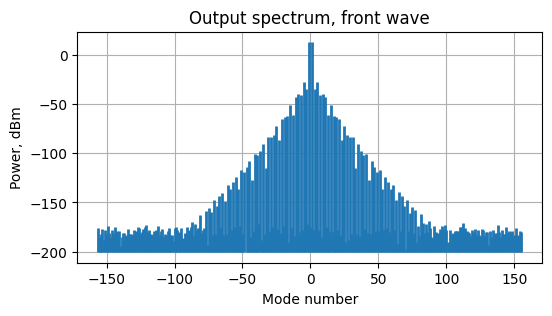

In [4]:
### Calculate the detuning of signals from hot resonances
def detuning(d1, d_min1, gamma, L, FSR, Power,  Dint,kappa, mu, alpha):
    
    delta0=(d1+d_min1)/2*2/kappa-np.fft.fftshift(Dint)[0]*2/kappa+2*np.sum(Power[:][0][:], axis=1)-Power[:, 0, np.fft.fftshift(mu)[0].astype(int)]
    delta1=(d1-np.fft.fftshift(Dint)[2])*2/kappa+2*np.sum(Power[:][0][:], axis=1)-Power[:,0, np.fft.fftshift(mu)[1].astype(int)]
    delta_min1=(d_min1-np.fft.fftshift(Dint)[-2])*2/kappa+2*np.sum(Power[:][0][:], axis=1)-Power[:,0, np.fft.fftshift(mu)[-1].astype(int)]
#     delta2=(3*d1-d_min1)/2*2/kappa-np.fft.fftshift(Dint)[4]*2/kappa+2*np.sum(Power, axis=1)-Power[:, np.fft.fftshift(mu)[2].astype(int)]
#     delta_min2=((3*d_min1-d1)/2-np.fft.fftshift(Dint)[-4])*2/kappa+2*np.sum(Power, axis=1)-Power[:, np.fft.fftshift(mu)[-2].astype(int)]

    return delta_min1, delta0,  delta1




sol1=data[3][:]
sol2=data[2][:]
        #sol1_back=data[6*j+3][:,:,:]
        #sol2_back=data[6*j+2]
    #     ans=np.sign(np.cos(np.angle(sol2[:,:,np.fft.fftshift(mu)[0].astype(int)])))
n_arange=int(nn)
detuning1_torch=data[4*j+2]
detuning2_torch=data[4*j+3]
coeff = single_ring.kappa_ex / FSR / 2 / np.pi 
to_power = single_ring.kappa/2/single_ring.g0*FSR
i = 0


power_modes=np.abs(sol1)**2#/np.shape(mu)
    #         power_modes_back=np.abs(sol1_back[:,i,:])**2
detunings=detuning(dOm1, dOm2, gamma, Leff, FSR, power_modes,  Dint, kappa_total, mu, alpha)
    #         detunings_back=detuning(dgs=detuning(dOm1, dOm2, gamma,beta2, Leff, FSR, power_modes,  Dint, kappa_total, mu, alpha)
    #         detunings_back=detuning(dOm1, dOm2, gamma,beta2, Leff, FSR, power_modes_back, power_modes, Dint, kappa_total, mu, alpha)


line_width = 2
font_size = 24
font_weight = 'bold'


pump_init = np.zeros_like(power_modes)
pump_init[:, 0, -n] = P_min
pump_init[:, 0, n] = P_pl
coeff = single_ring.kappa_ex / FSR / 2 / np.pi 
to_power = single_ring.kappa/2/single_ring.g0*FSR

#here numb is time slice

numb = 3000


output_power = np.sum(np.abs(np.sqrt(pump_init[:n_arange,:]/hbar/single_ring.w0) - np.sqrt(coeff) * (sol1)[:n_arange, :] * np.sqrt(to_power))**2 * hbar * single_ring.w0, axis = 1)*1e3
intracavity_power = np.sum((power_modes*single_ring.kappa/2/single_ring.g0*hbar*single_ring.w0*FSR)[:n_arange, :], axis = 1)
output_power_modes = np.abs(np.sqrt(pump_init[:n_arange,:]/hbar/single_ring.w0) - np.sqrt(coeff) * (sol1)[:n_arange, :] * np.sqrt(to_power))**2 * hbar * single_ring.w0



for numb in range(5000, 5001):
#for i in range(-150, 150):
    coeff = single_ring.kappa_ex / FSR / 2 / np.pi 
    to_power = single_ring.kappa/2/single_ring.g0*FSR
    fig = plt.figure(figsize=(6,3), facecolor = 'white')
    for i in mu.astype(int)[100:-100]:
        #power_min = np.min(10*np.log10(np.abs(np.sqrt(pump_init[0]/hbar/single_ring.w0) - np.sqrt(coeff) * (sol1)[0] * np.sqrt(to_power))**2 * hbar * single_ring.w0 * 1e3))
        #power_max = 10*np.log10(np.abs(np.sqrt(pump_init[0][i]/hbar/single_ring.w0) - np.sqrt(coeff) * (sol1)[0][i] * np.sqrt(to_power))**2 * hbar * single_ring.w0 * 1e3)
        #plt.vlines(i, 0, 10 * np.log(np.abs(sol1[0][i]) ** 2), linewidth = line_width)
        #print(np.abs(sol1[0][i])**2)
        power_min = np.min(10*np.log10(np.abs(np.sqrt(pump_init[numb][0]/hbar/single_ring.w0) - np.sqrt(coeff) * (sol1[numb][0]) * np.sqrt(to_power))**2 * hbar * single_ring.w0 * 1e3))
        power_max = 10*np.log10(np.abs(np.sqrt(pump_init[numb][0][i]/hbar/single_ring.w0) - np.sqrt(coeff) * (sol1[numb][0][i]) * np.sqrt(to_power))**2 * hbar * single_ring.w0 * 1e3)
        plt.vlines(i, power_min, power_max, linewidth = line_width)
        
    plt.title('Output spectrum, front wave')
    plt.xlabel('Mode number')
    plt.ylabel('Power, dBm')
    plt.grid()
    plt.show()
    
# here I try to find the differense for thr different numbers of value

Text(0, 0.5, 'Mode index')

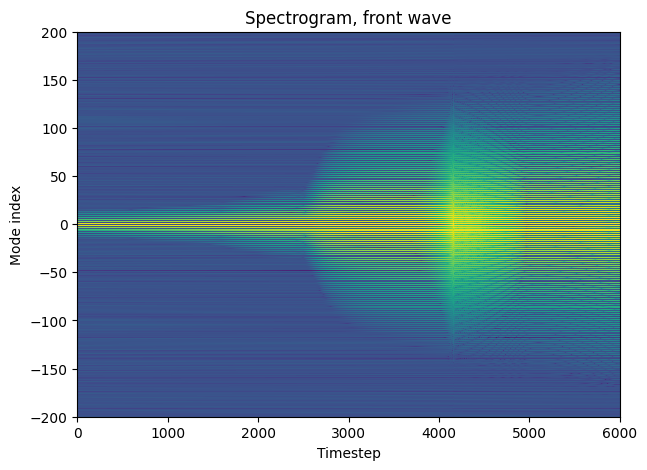

In [7]:
#n - номер моды
#так получаем по моде все частоты

sol1=data[1][:]
sol2=data[0][:]
        #sol1_back=data[6*j+3][:,:,:]
        #sol2_back=data[6*j+2]
    #     ans=np.sign(np.cos(np.angle(sol2[:,:,np.fft.fftshift(mu)[0].astype(int)])))
n_arange=int(nn)
detuning1_torch=data[4*j+2]
detuning2_torch=data[4*j+3]
coeff = single_ring.kappa_ex / FSR / 2 / np.pi 
to_power = single_ring.kappa/2/single_ring.g0*FSR
i = 0


power_modes=np.abs(sol1)**2#/np.shape(mu)
    #         power_modes_back=np.abs(sol1_back[:,i,:])**2
detunings=detuning(dOm1, dOm2, gamma, Leff, FSR, power_modes,  Dint, kappa_total, mu, alpha)
    #         detunings_back=detuning(dgs=detuning(dOm1, dOm2, gamma,beta2, Leff, FSR, power_modes,  Dint, kappa_total, mu, alpha)
    #         detunings_back=detuning(dOm1, dOm2, gamma,beta2, Leff, FSR, power_modes_back, power_modes, Dint, kappa_total, mu, alpha)


line_width = 2
font_size = 24
font_weight = 'bold'


pump_init = np.zeros_like(power_modes)
pump_init[:, 0, -n] = P_min
pump_init[:, 0, n] = P_pl
coeff = single_ring.kappa_ex / FSR / 2 / np.pi 
#to_power = single_ring.kappa/2/single_ring.g0*FSR(data[1].T[1]**2).sum(axis=0)[n]

power_dBm = 10*np.log10((power_modes[1:,0,np.fft.fftshift(mu).astype(int)]*single_ring.kappa/2/single_ring.g0*hbar*single_ring.w0*FSR))
fig = plt.figure(figsize=(7, 5))
plt.pcolormesh(np.arange(np.shape(power_dBm)[0]), mu, np.fft.fftshift(power_dBm.T, axes = 0))#, vmin = 0)
plt.ylim(-200,200)
plt.xlim(0, nn)
plt.title('Spectrogram, front wave')
plt.xlabel('Timestep')
plt.ylabel('Mode index')

## Большие циклы

In [22]:
fs = [1.7, 1.9]

100%|██████████████████████████████████████████████████████████████████████████████| 5999/5999 [31:33<00:00,  3.17it/s]


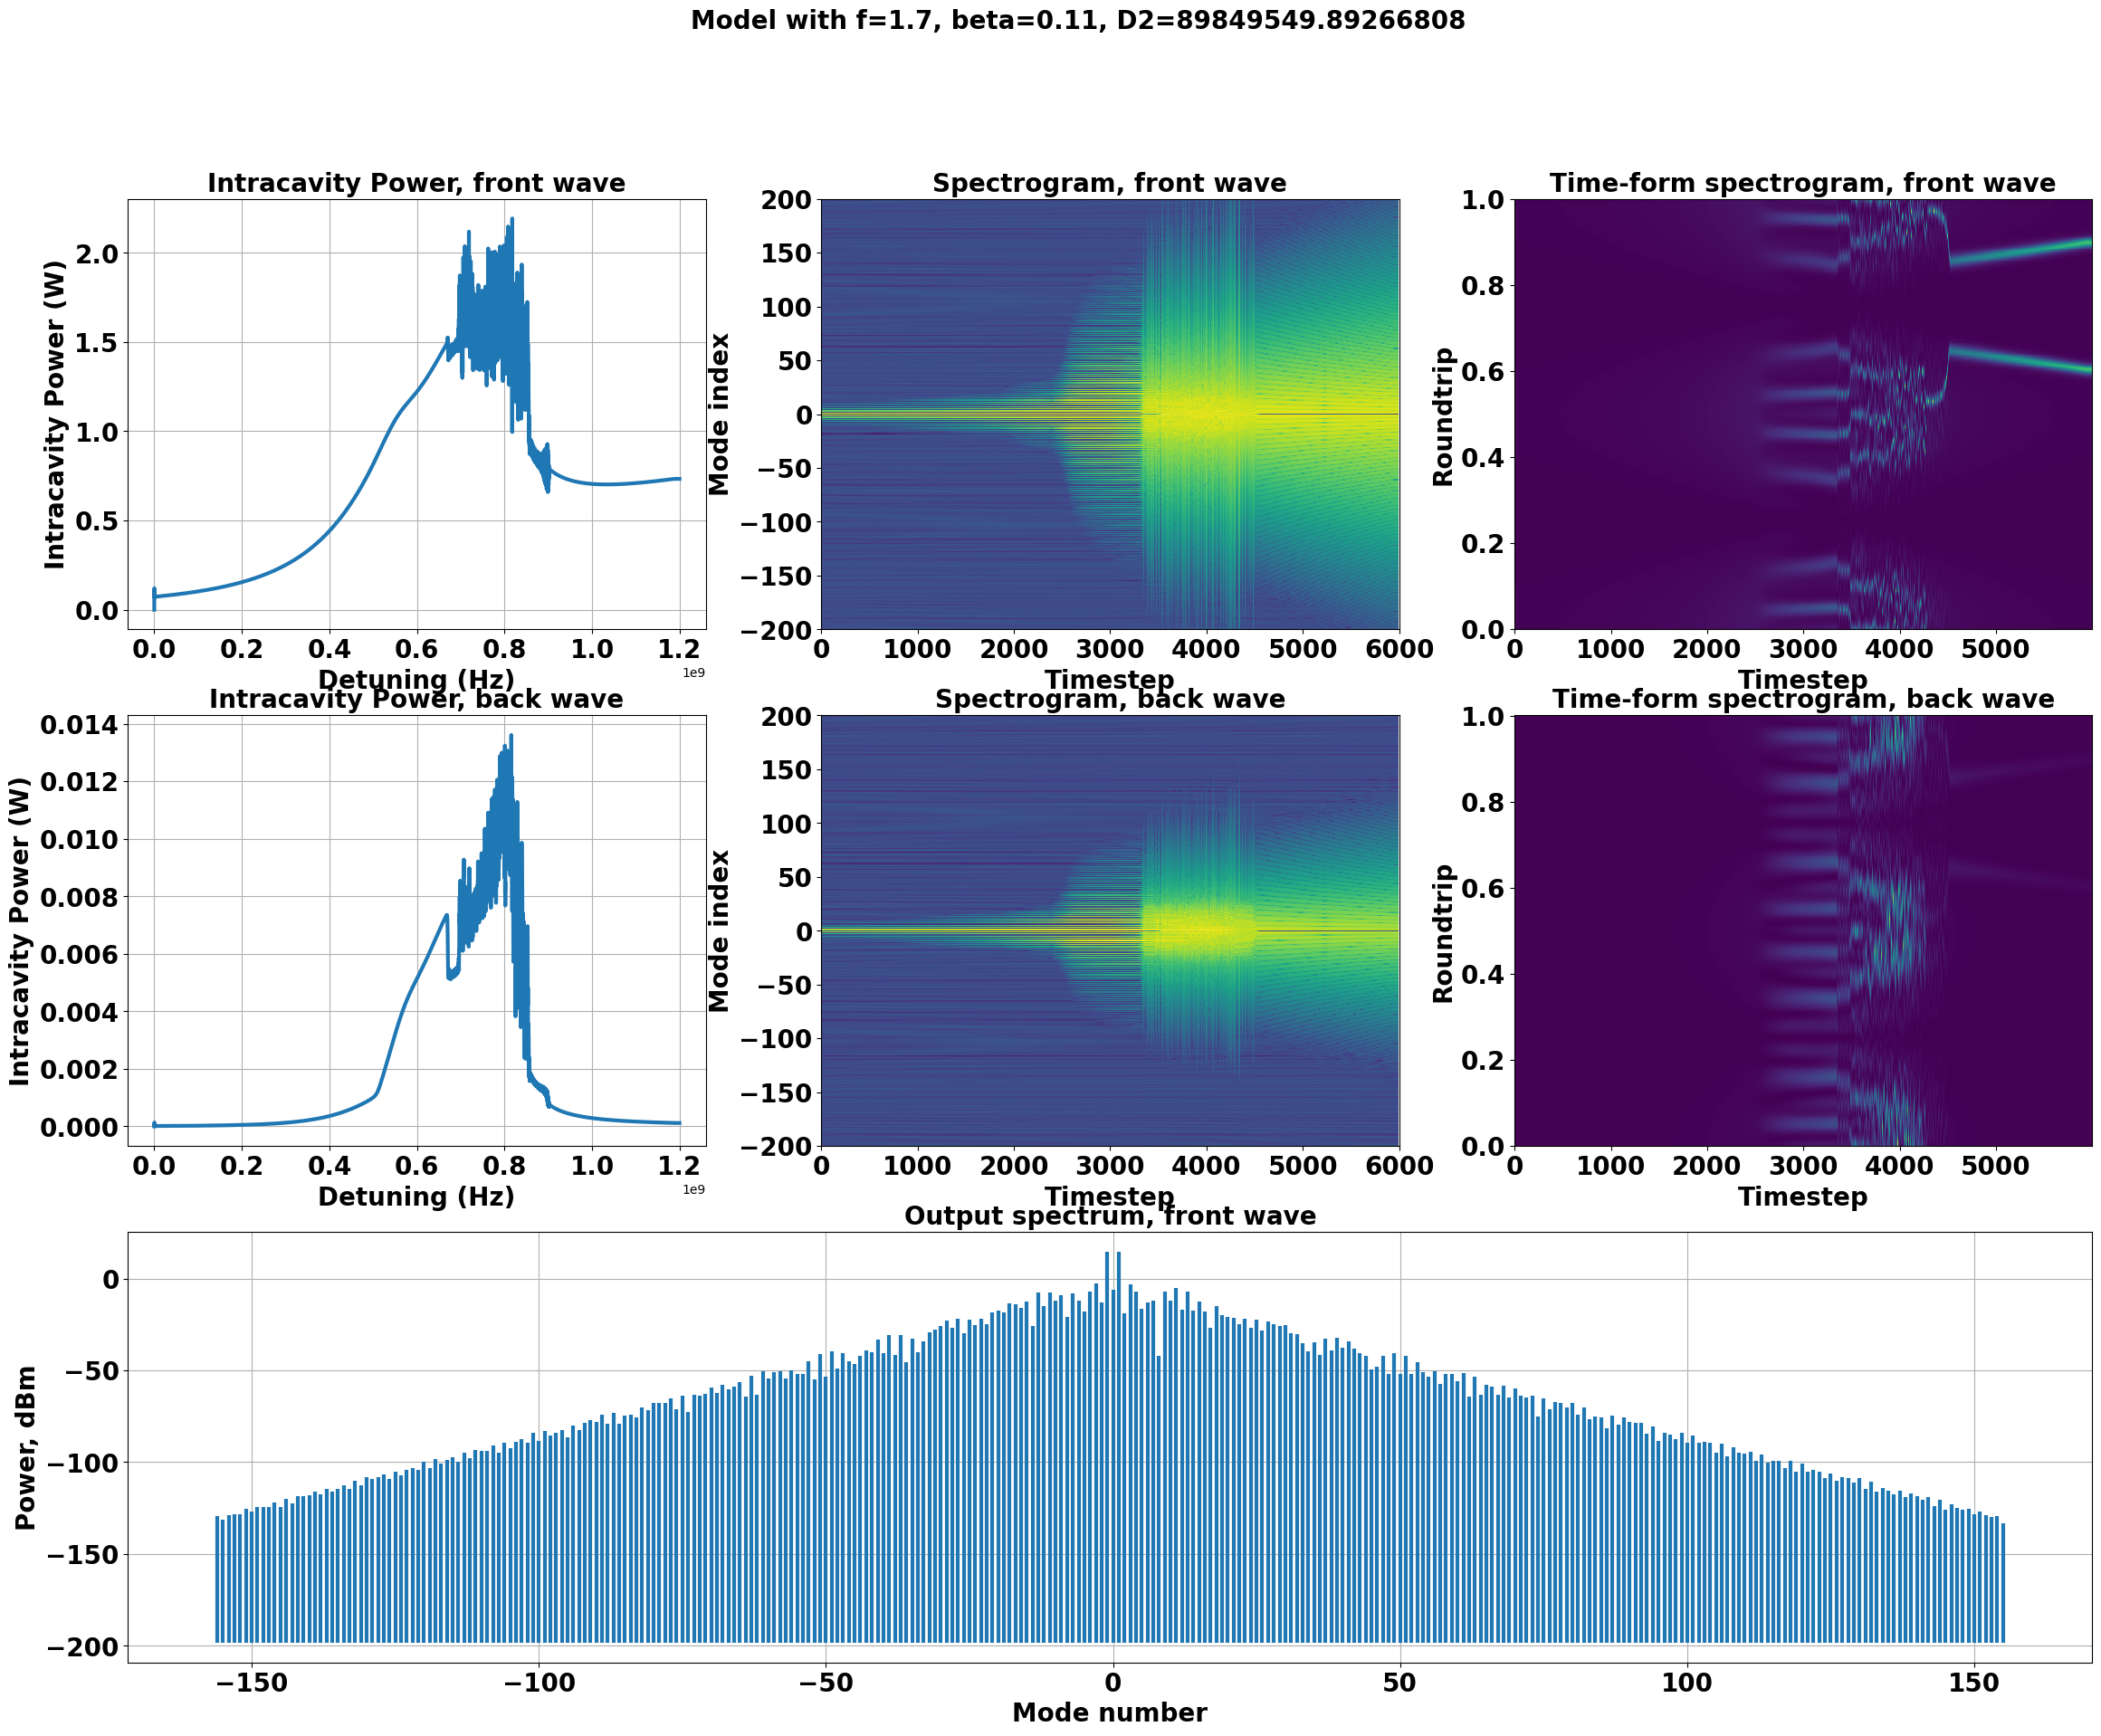

100%|████████████████████████████████████████████████████████████████████████████| 5999/5999 [7:49:58<00:00,  4.70s/it]


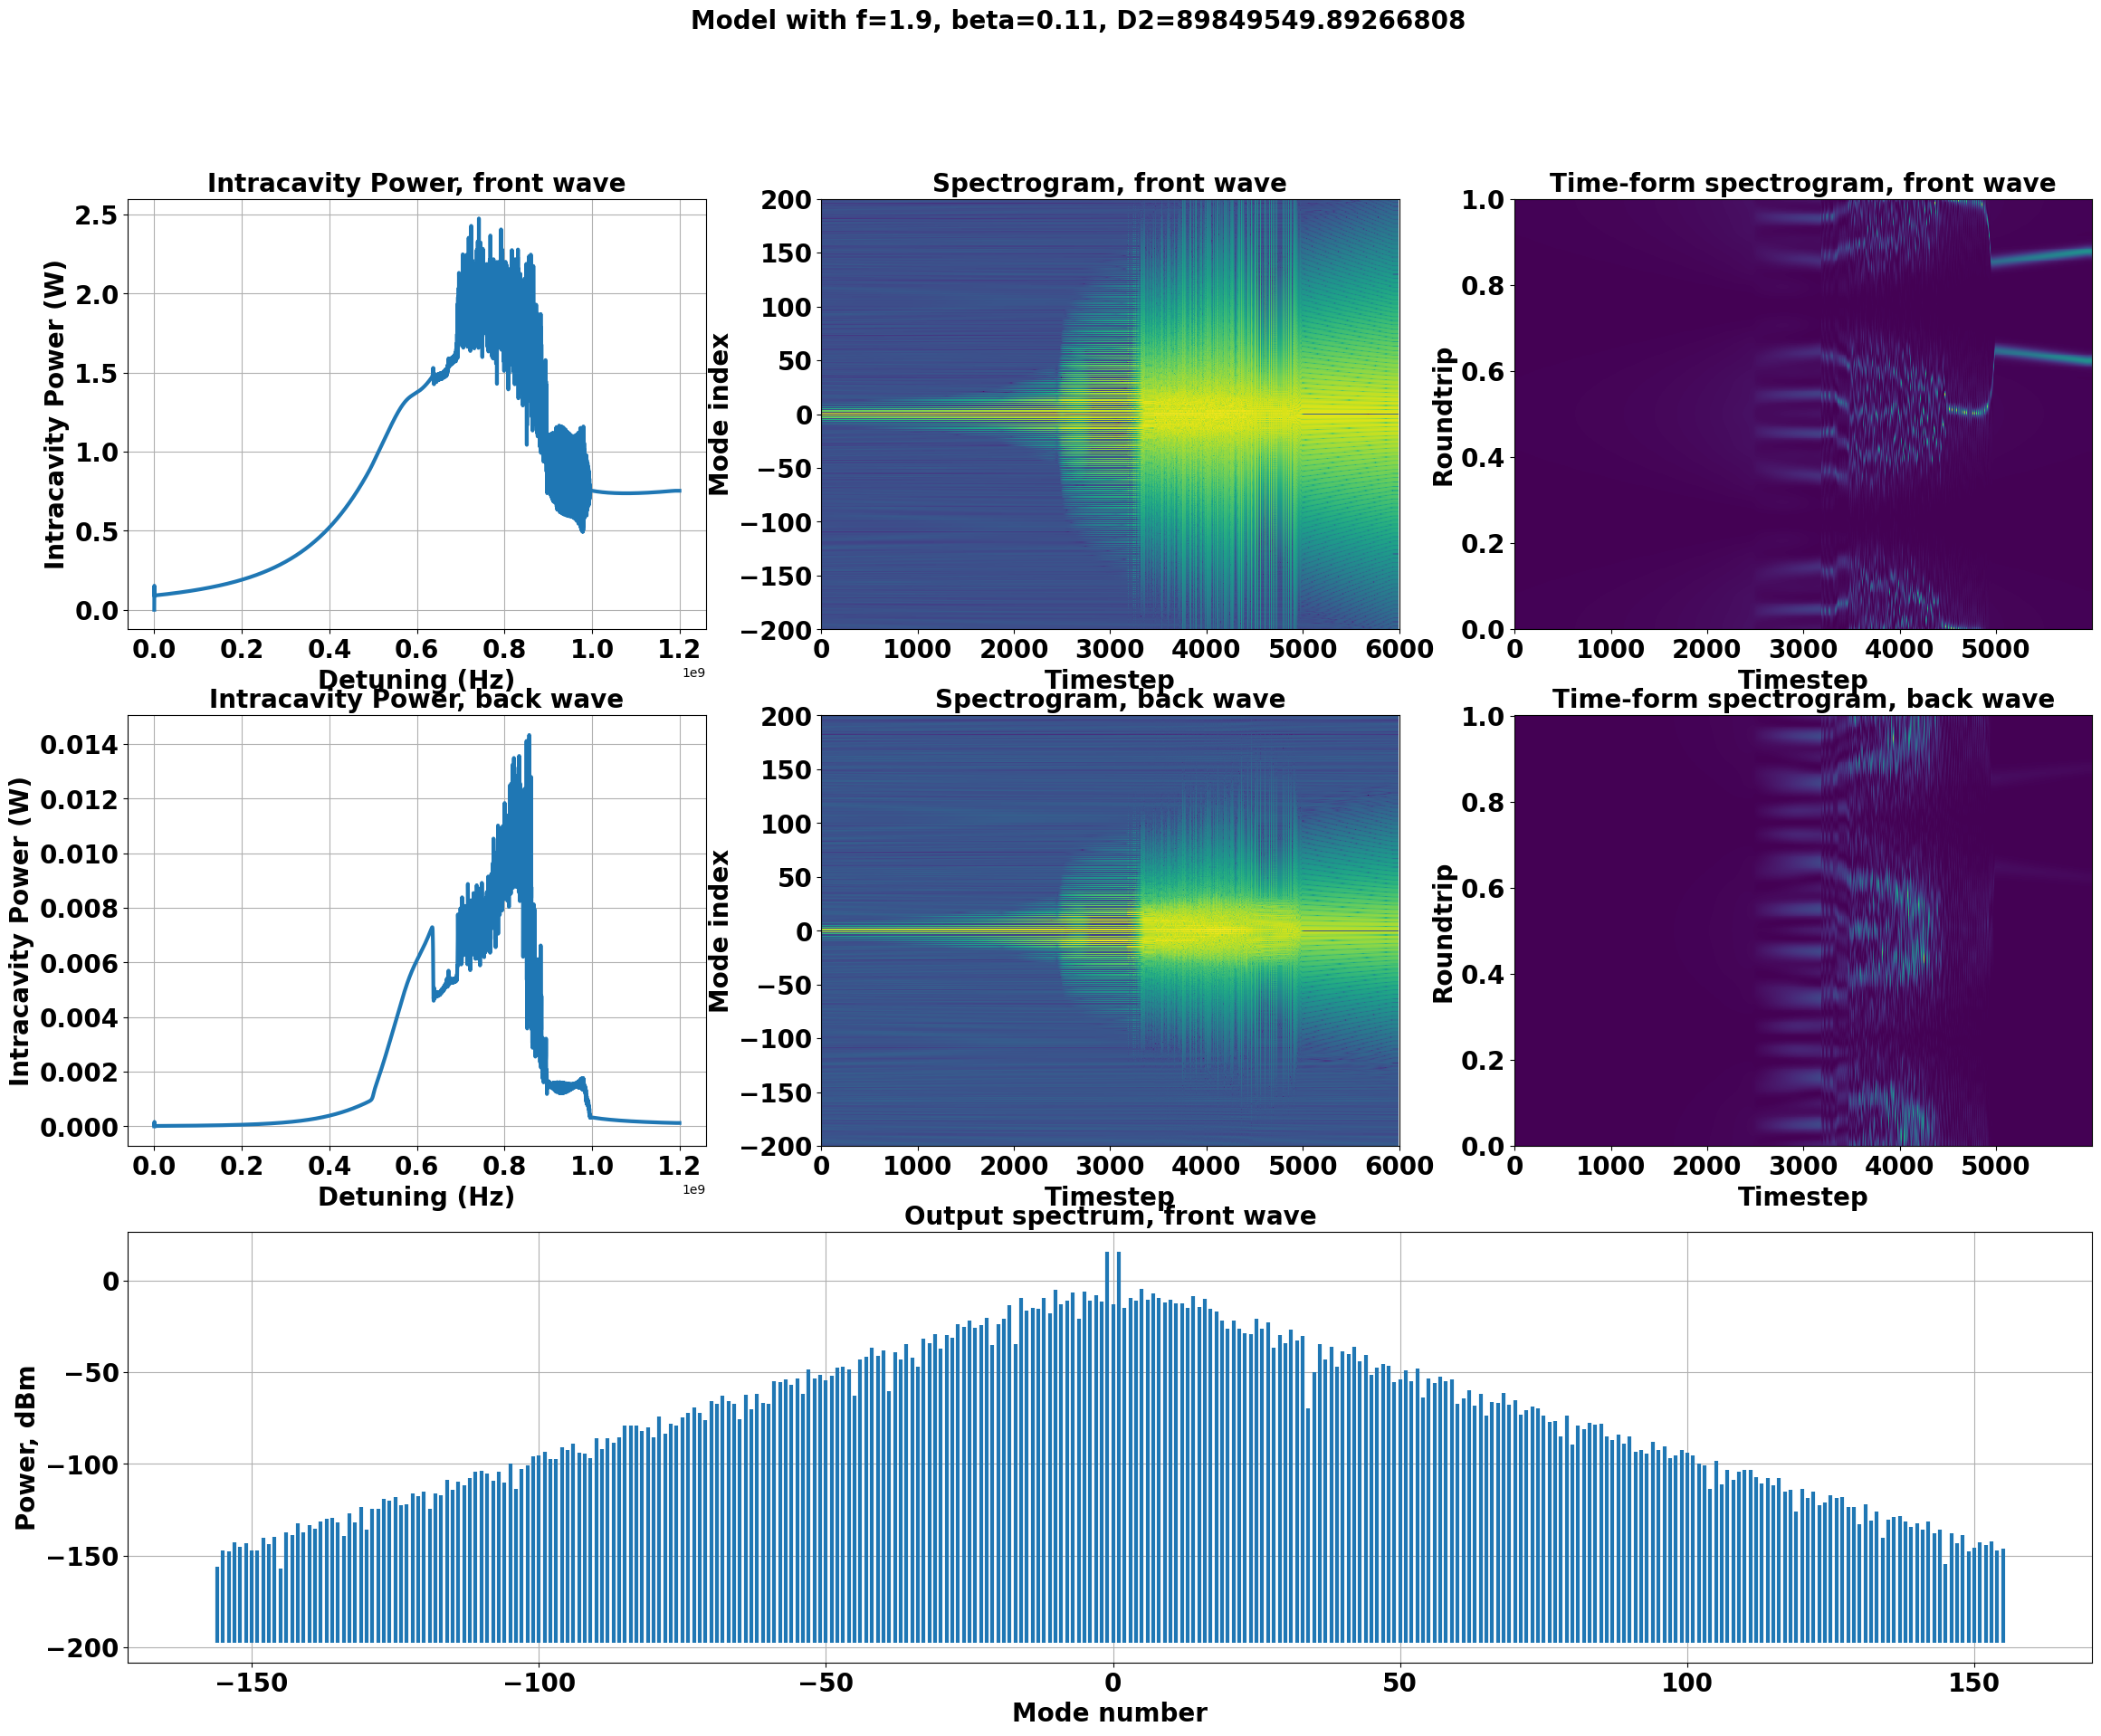

In [23]:
for f in fs:
    Pump=np.zeros(len(mu), dtype='complex128')
    w_0 = 2*pi*c/wavelength
    P_pl = f**2*((kappa_0+kappa_ex)**3*hbar*w_0)/(8*g0*kappa_ex)
    P_min = f**2*((kappa_0+kappa_ex)**3*hbar*w_0)/(8*g0*kappa_ex)
    Pump[n]=np.sqrt(P_pl)
    Pump[-n]=np.sqrt(P_min)


    single_ring=Resonator(PhysicalParameters)
    data=[]
    n_iter=1
    probability=np.zeros(n_iter)


    j = 0

    data=single_ring.Propagate_SplitStep_dual_back(simulation_parameters, Pump, Seed=[0], dt=1e-3);
    
    sol1=data[1][:]
    sol3=data[3][:]
    n_arange=int(nn)
    detuning1_torch=data[4*j+2]
    detuning2_torch=data[4*j+3]
    i = 0
    n_arange=int(nn)
    coeff = single_ring.kappa_ex / FSR / 2 / np.pi 
    to_power = single_ring.kappa/2/single_ring.g0*FSR
    
    line_width = 3
    font_size = 20
    font_weight = 'bold'
    
    power_modes=np.abs(sol1)**2
    detunings=detuning(dOm1, dOm2, gamma, Leff, FSR, power_modes,  Dint, kappa_total, mu, alpha)

    pump_init = np.zeros_like(power_modes)
    pump_init[:, 0, -n] = P_min
    pump_init[:, 0, n] = P_pl
    coeff = single_ring.kappa_ex / FSR / 2 / np.pi 

    
    fig = plt.figure(figsize=(28,21))
    
    numb = 4000
    plt.subplot(3,1,3)
    for i in mu.astype(int)[100:-100]:
        power_min = np.min(10*np.log10(np.abs(np.sqrt(pump_init[numb][0]/hbar/single_ring.w0) - np.sqrt(coeff) * (sol1[numb][0]) * np.sqrt(to_power))**2 * hbar * single_ring.w0 * 1e3))
        power_max = 10*np.log10(np.abs(np.sqrt(pump_init[numb][0][i]/hbar/single_ring.w0) - np.sqrt(coeff) * (sol1[numb][0][i]) * np.sqrt(to_power))**2 * hbar * single_ring.w0 * 1e3)
        plt.vlines(i, power_min, power_max, linewidth = line_width)
    plt.title('Output spectrum, front wave', fontsize = font_size, fontweight = font_weight)
    plt.xlabel('Mode number', fontsize = font_size, fontweight = font_weight)
    plt.ylabel('Power, dBm', fontsize = font_size, fontweight = font_weight)
    plt.grid()
    plt.xticks(fontsize = font_size, fontweight = font_weight)
    plt.yticks(fontsize = font_size, fontweight = font_weight)

    
    plt.subplot(3,3,1)
    plt.xlabel('Detuning (Hz)', fontsize = font_size, fontweight = font_weight)
    plt.title('Intracavity Power, front wave', fontsize = font_size, fontweight = font_weight)
    plt.ylabel('Intracavity Power (W)', fontsize = font_size, fontweight = font_weight)
    plt.plot(np.arange(n_arange)/dzeta, (abs(data[1].T)**2).sum(axis=0)[0], linewidth = line_width)
    plt.grid()
    plt.xticks(fontsize = font_size, fontweight = font_weight)
    plt.yticks(fontsize = font_size, fontweight = font_weight)

    
    plt.subplot(3,3,4)
    plt.xlabel('Detuning (Hz)', fontsize = font_size, fontweight = font_weight)
    plt.title('Intracavity Power, back wave', fontsize = font_size, fontweight = font_weight)
    plt.ylabel('Intracavity Power (W)', fontsize = font_size, fontweight = font_weight)
    plt.plot(np.arange(n_arange)/dzeta, (abs(data[3].T)**2).sum(axis=0)[0], linewidth = line_width)
    plt.grid()
    plt.xticks(fontsize = font_size, fontweight = font_weight)
    plt.yticks(fontsize = font_size, fontweight = font_weight)
    
    
    
    
    power_modes=np.abs(sol1)**2
    detunings=detuning(dOm1, dOm2, gamma, Leff, FSR, power_modes,  Dint, kappa_total, mu, alpha)

    pump_init = np.zeros_like(power_modes)
    pump_init[:, 0, -n] = P_min
    pump_init[:, 0, n] = P_pl
    coeff = single_ring.kappa_ex / FSR / 2 / np.pi 

    plt.subplot(3,3,2)
    power_dBm = 10*np.log10((power_modes[1:,0,np.fft.fftshift(mu).astype(int)]*single_ring.kappa/2/single_ring.g0*hbar*single_ring.w0*FSR))
    plt.pcolormesh(np.arange(np.shape(power_dBm)[0]), mu, np.fft.fftshift(power_dBm.T, axes = 0))#, vmin = 0)
    plt.ylim(-200,200)
    plt.xlim(0, nn)
    plt.title('Spectrogram, front wave', fontsize = font_size, fontweight = font_weight)
    plt.xlabel('Timestep', fontsize = font_size, fontweight = font_weight)
    plt.ylabel('Mode index', fontsize = font_size, fontweight = font_weight)
    plt.xticks(fontsize = font_size, fontweight = font_weight)
    plt.yticks(fontsize = font_size, fontweight = font_weight)
    
    
    
    power_modes=np.abs(sol3)**2
    detunings=detuning(dOm1, dOm2, gamma, Leff, FSR, power_modes,  Dint, kappa_total, mu, alpha)

    pump_init = np.zeros_like(power_modes)
    pump_init[:, 0, -n] = P_min
    pump_init[:, 0, n] = P_pl
    coeff = single_ring.kappa_ex / FSR / 2 / np.pi 


    plt.subplot(3,3,5)
    power_dBm = 10*np.log10((power_modes[1:,0,np.fft.fftshift(mu).astype(int)]*single_ring.kappa/2/single_ring.g0*hbar*single_ring.w0*FSR))
    plt.pcolormesh(np.arange(np.shape(power_dBm)[0]), mu, np.fft.fftshift(power_dBm.T, axes = 0))
    plt.ylim(-200,200)
    plt.xlim(0, nn)
    plt.title('Spectrogram, back wave', fontsize = font_size, fontweight = font_weight)
    plt.xlabel('Timestep', fontsize = font_size, fontweight = font_weight)
    plt.ylabel('Mode index', fontsize = font_size, fontweight = font_weight)
    plt.xticks(fontsize = font_size, fontweight = font_weight)
    plt.yticks(fontsize = font_size, fontweight = font_weight)
    
    
    plt.subplot(3,3,3)
    plt.pcolormesh(np.arange(nn), np.linspace(0, 1, 512), (np.abs(np.fft.ifft(sol1).T)**2)[:,0,:])
    plt.title('Time-form spectrogram, front wave', fontsize = font_size, fontweight = font_weight)
    plt.xlabel('Timestep', fontsize = font_size, fontweight = font_weight)
    plt.ylabel('Roundtrip', fontsize = font_size, fontweight = font_weight)
    plt.xticks(fontsize = font_size, fontweight = font_weight)
    plt.yticks(fontsize = font_size, fontweight = font_weight)
    
    plt.subplot(3,3,6)
    plt.pcolormesh(np.arange(nn), np.linspace(0, 1, 512), (np.abs(np.fft.ifft(sol3).T)**2)[:,0,:])
    plt.title('Time-form spectrogram, back wave', fontsize = font_size, fontweight = font_weight)
    plt.xlabel('Timestep', fontsize = font_size, fontweight = font_weight)
    plt.ylabel('Roundtrip', fontsize = font_size, fontweight = font_weight)
    plt.xticks(fontsize = font_size, fontweight = font_weight)
    plt.yticks(fontsize = font_size, fontweight = font_weight)
    
    plt.suptitle("Model with f=" + str(f) + ", beta=" + str(beta) + ", D2=" + str(D2), fontweight = font_weight, fontsize = font_size)
    plt.savefig("Model with f=" + str(f) + ", beta=" + str(beta) + ", D2=" + str(D2) +'.png')#, dpi = 300)
    plt.show()
    np.save("Model with f=" + str(f) + ", beta=" + str(beta) + ", D2=" + str(D2) + '.npy', data )

100%|████████████████████████████████████████████████████████████████████████████| 5999/5999 [2:15:03<00:00,  1.35s/it]


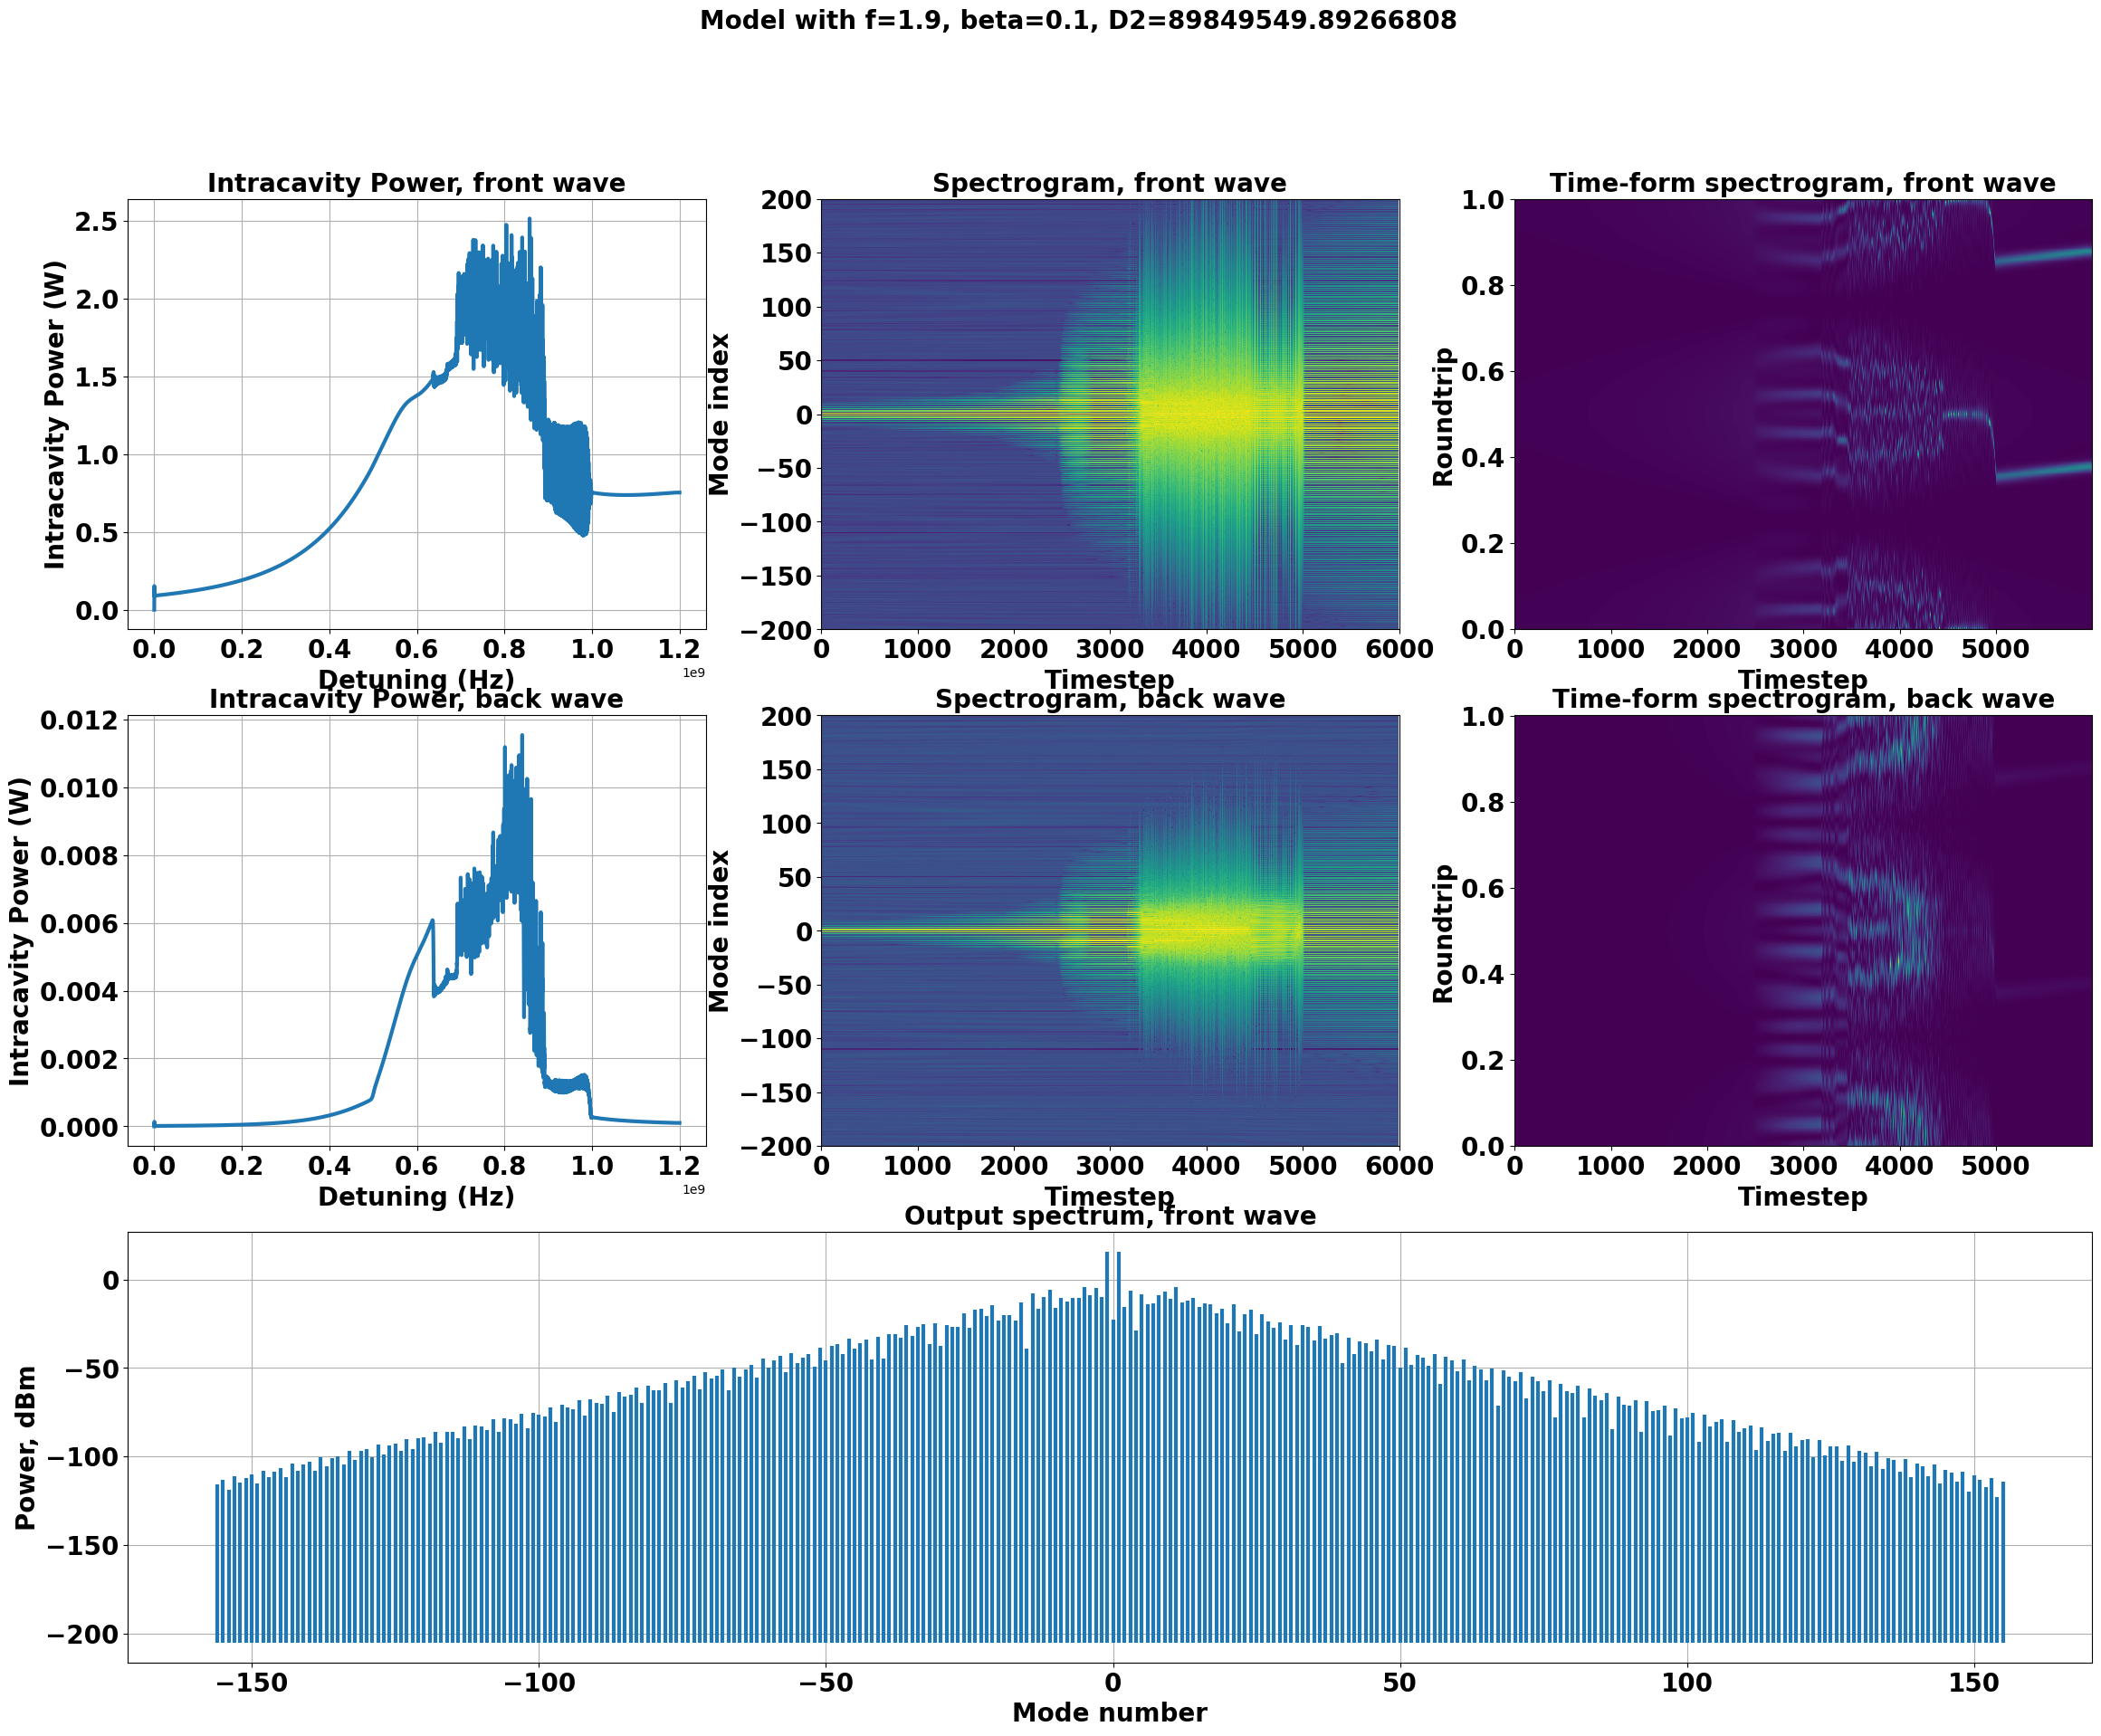

100%|███████████████████████████████████████████████████████████████████████████| 5999/5999 [11:39:19<00:00,  6.99s/it]


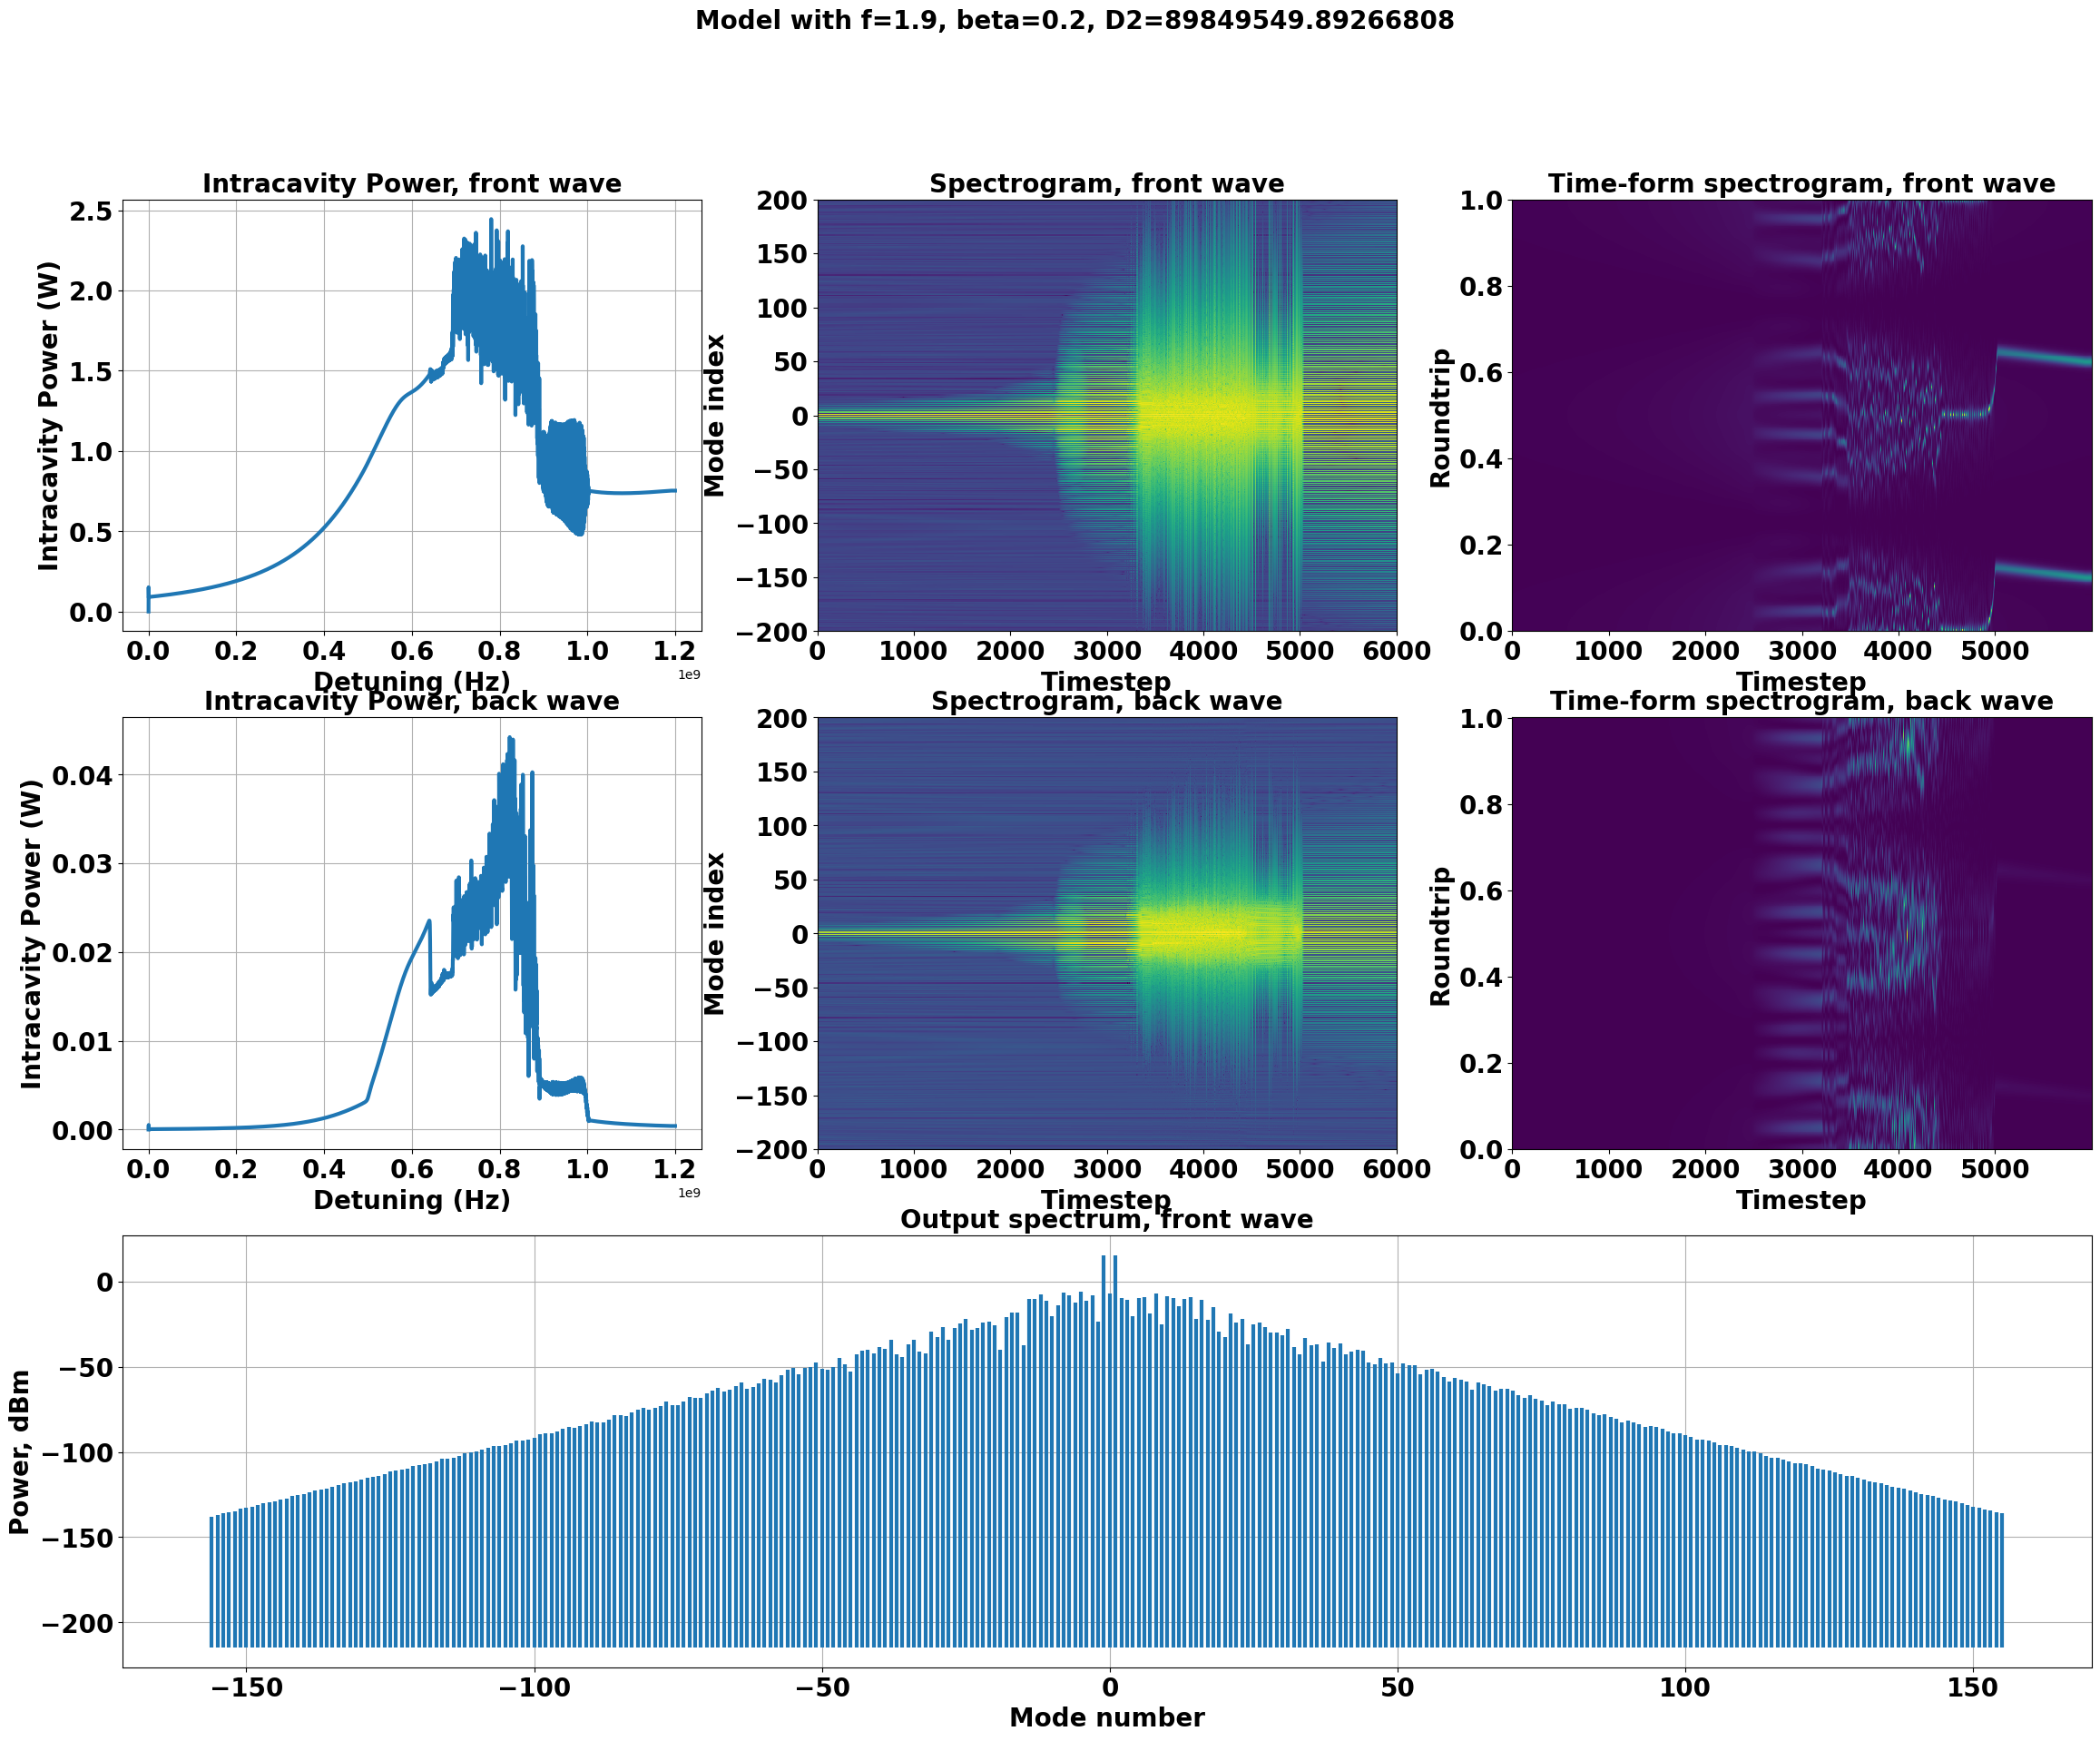

100%|██████████████████████████████████████████████████████████████████████████████| 5999/5999 [53:44<00:00,  1.86it/s]


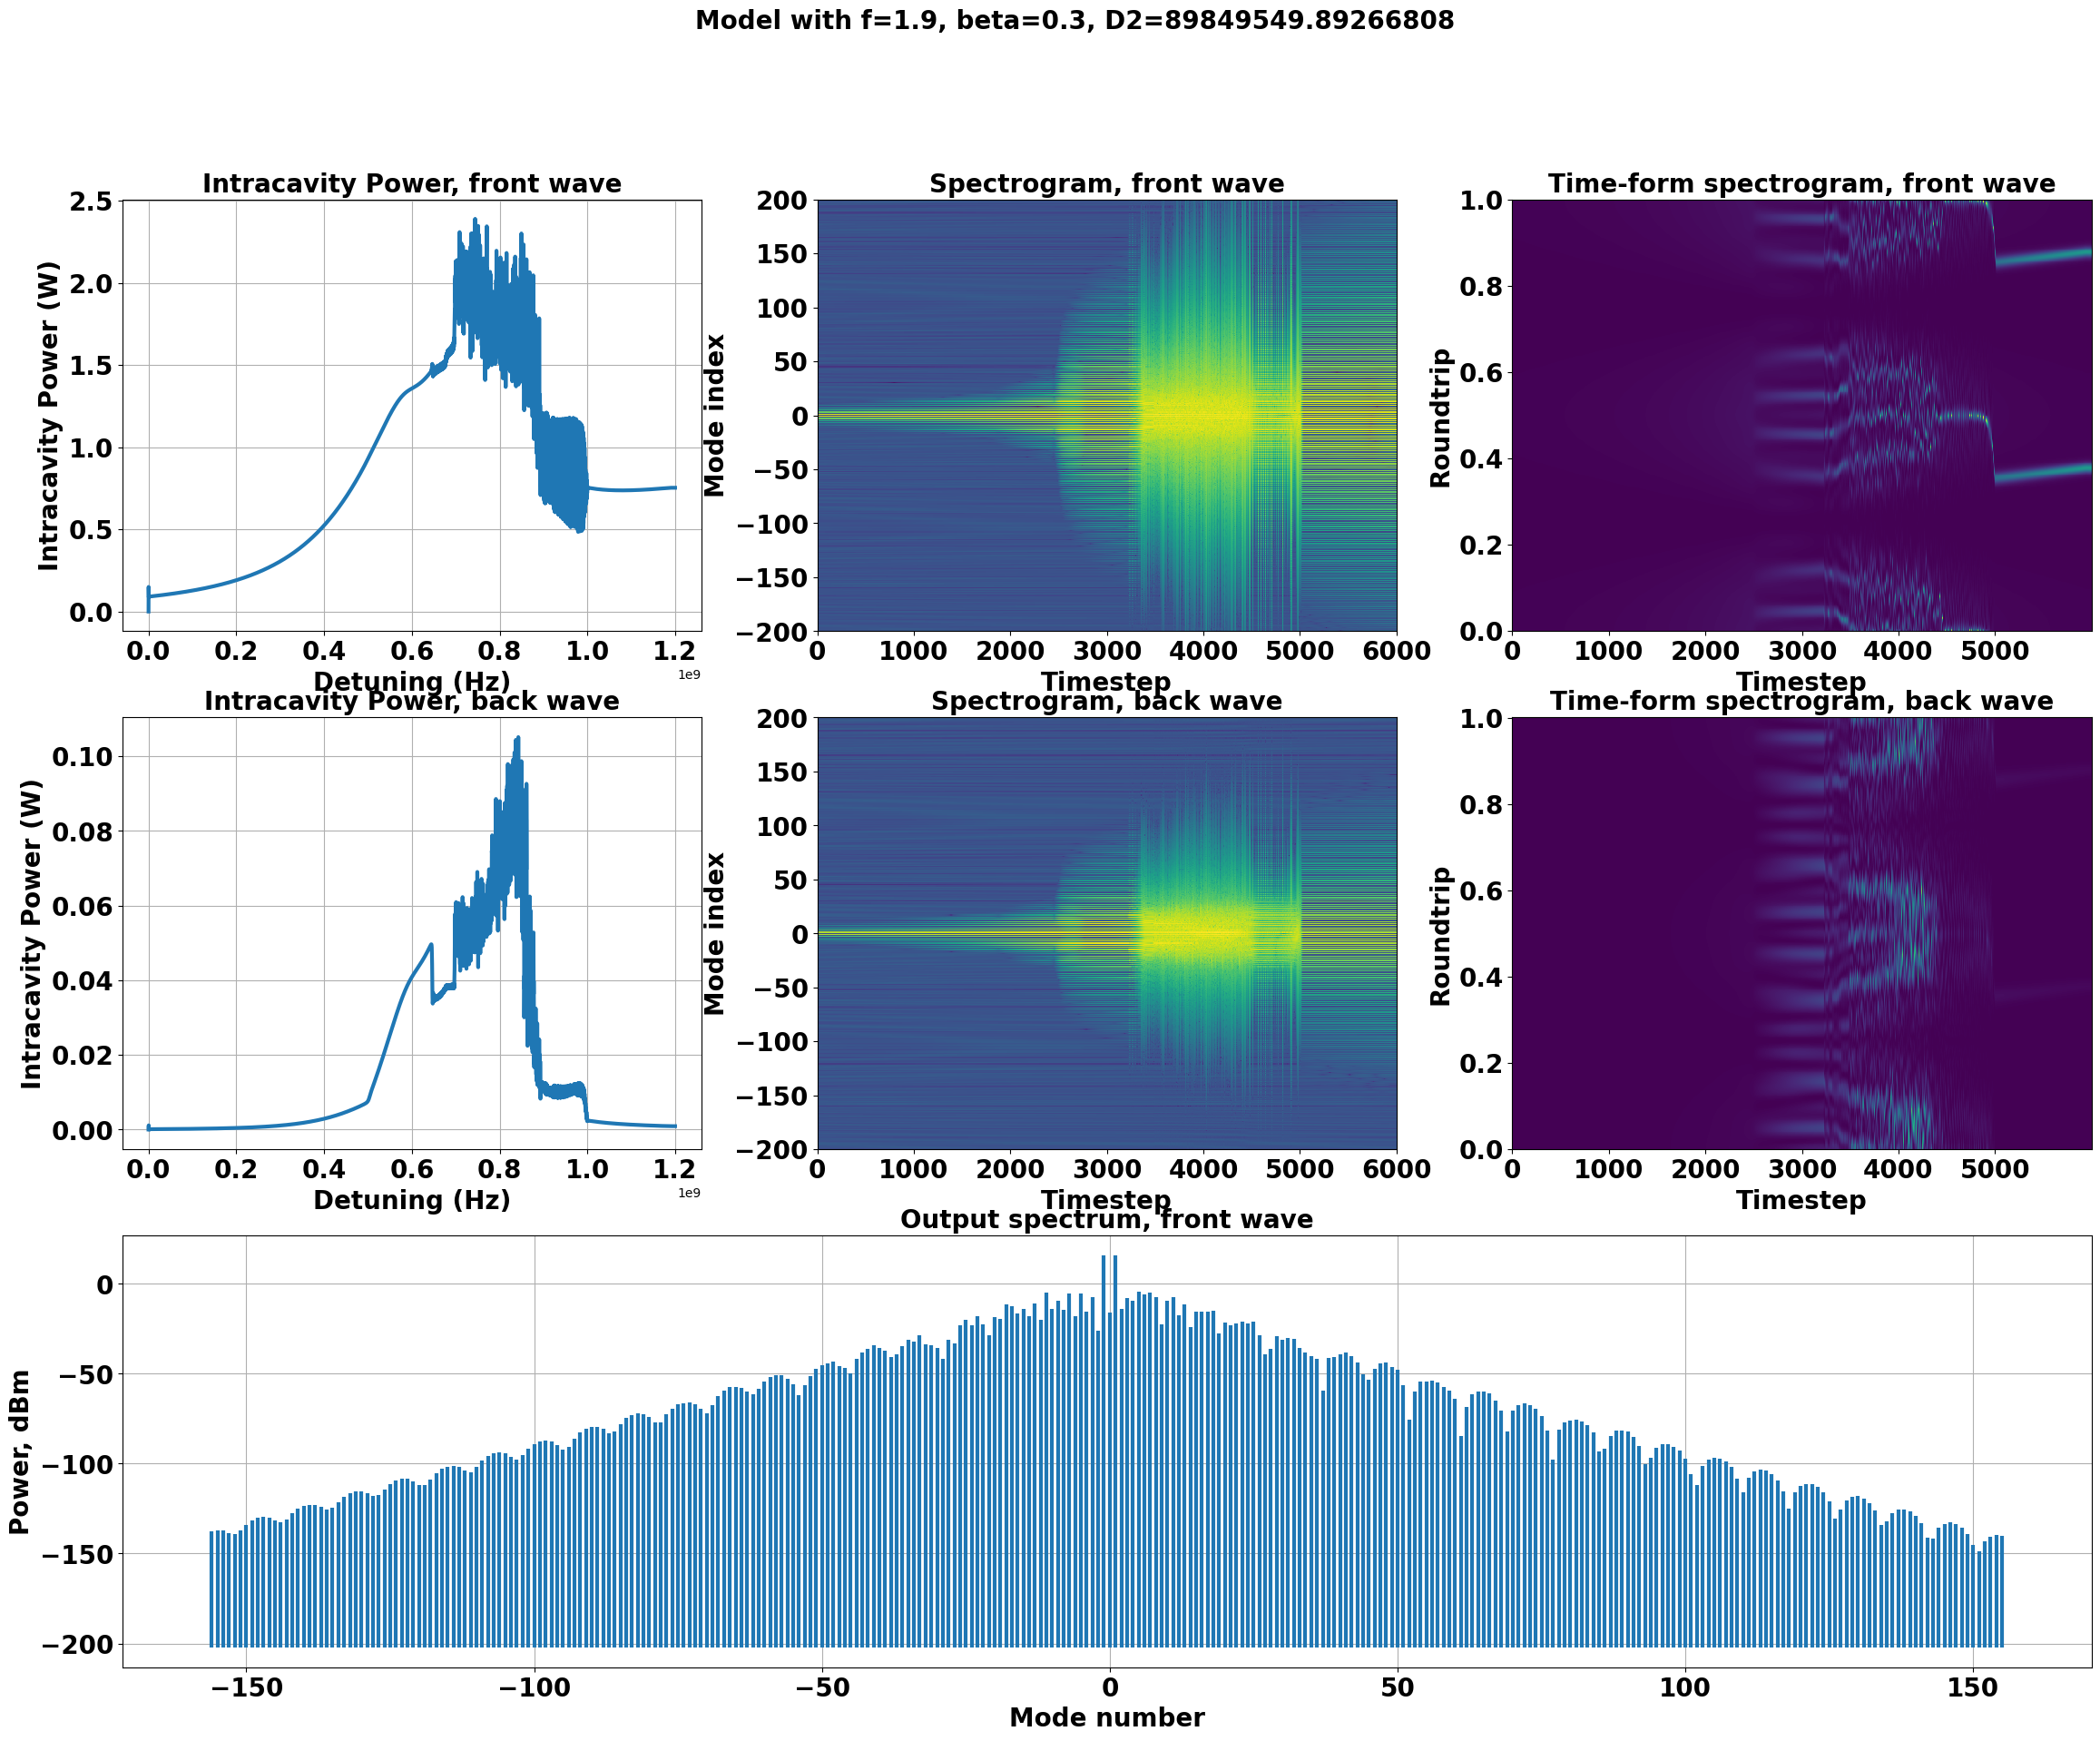

100%|████████████████████████████████████████████████████████████████████████████| 5999/5999 [2:21:36<00:00,  1.42s/it]


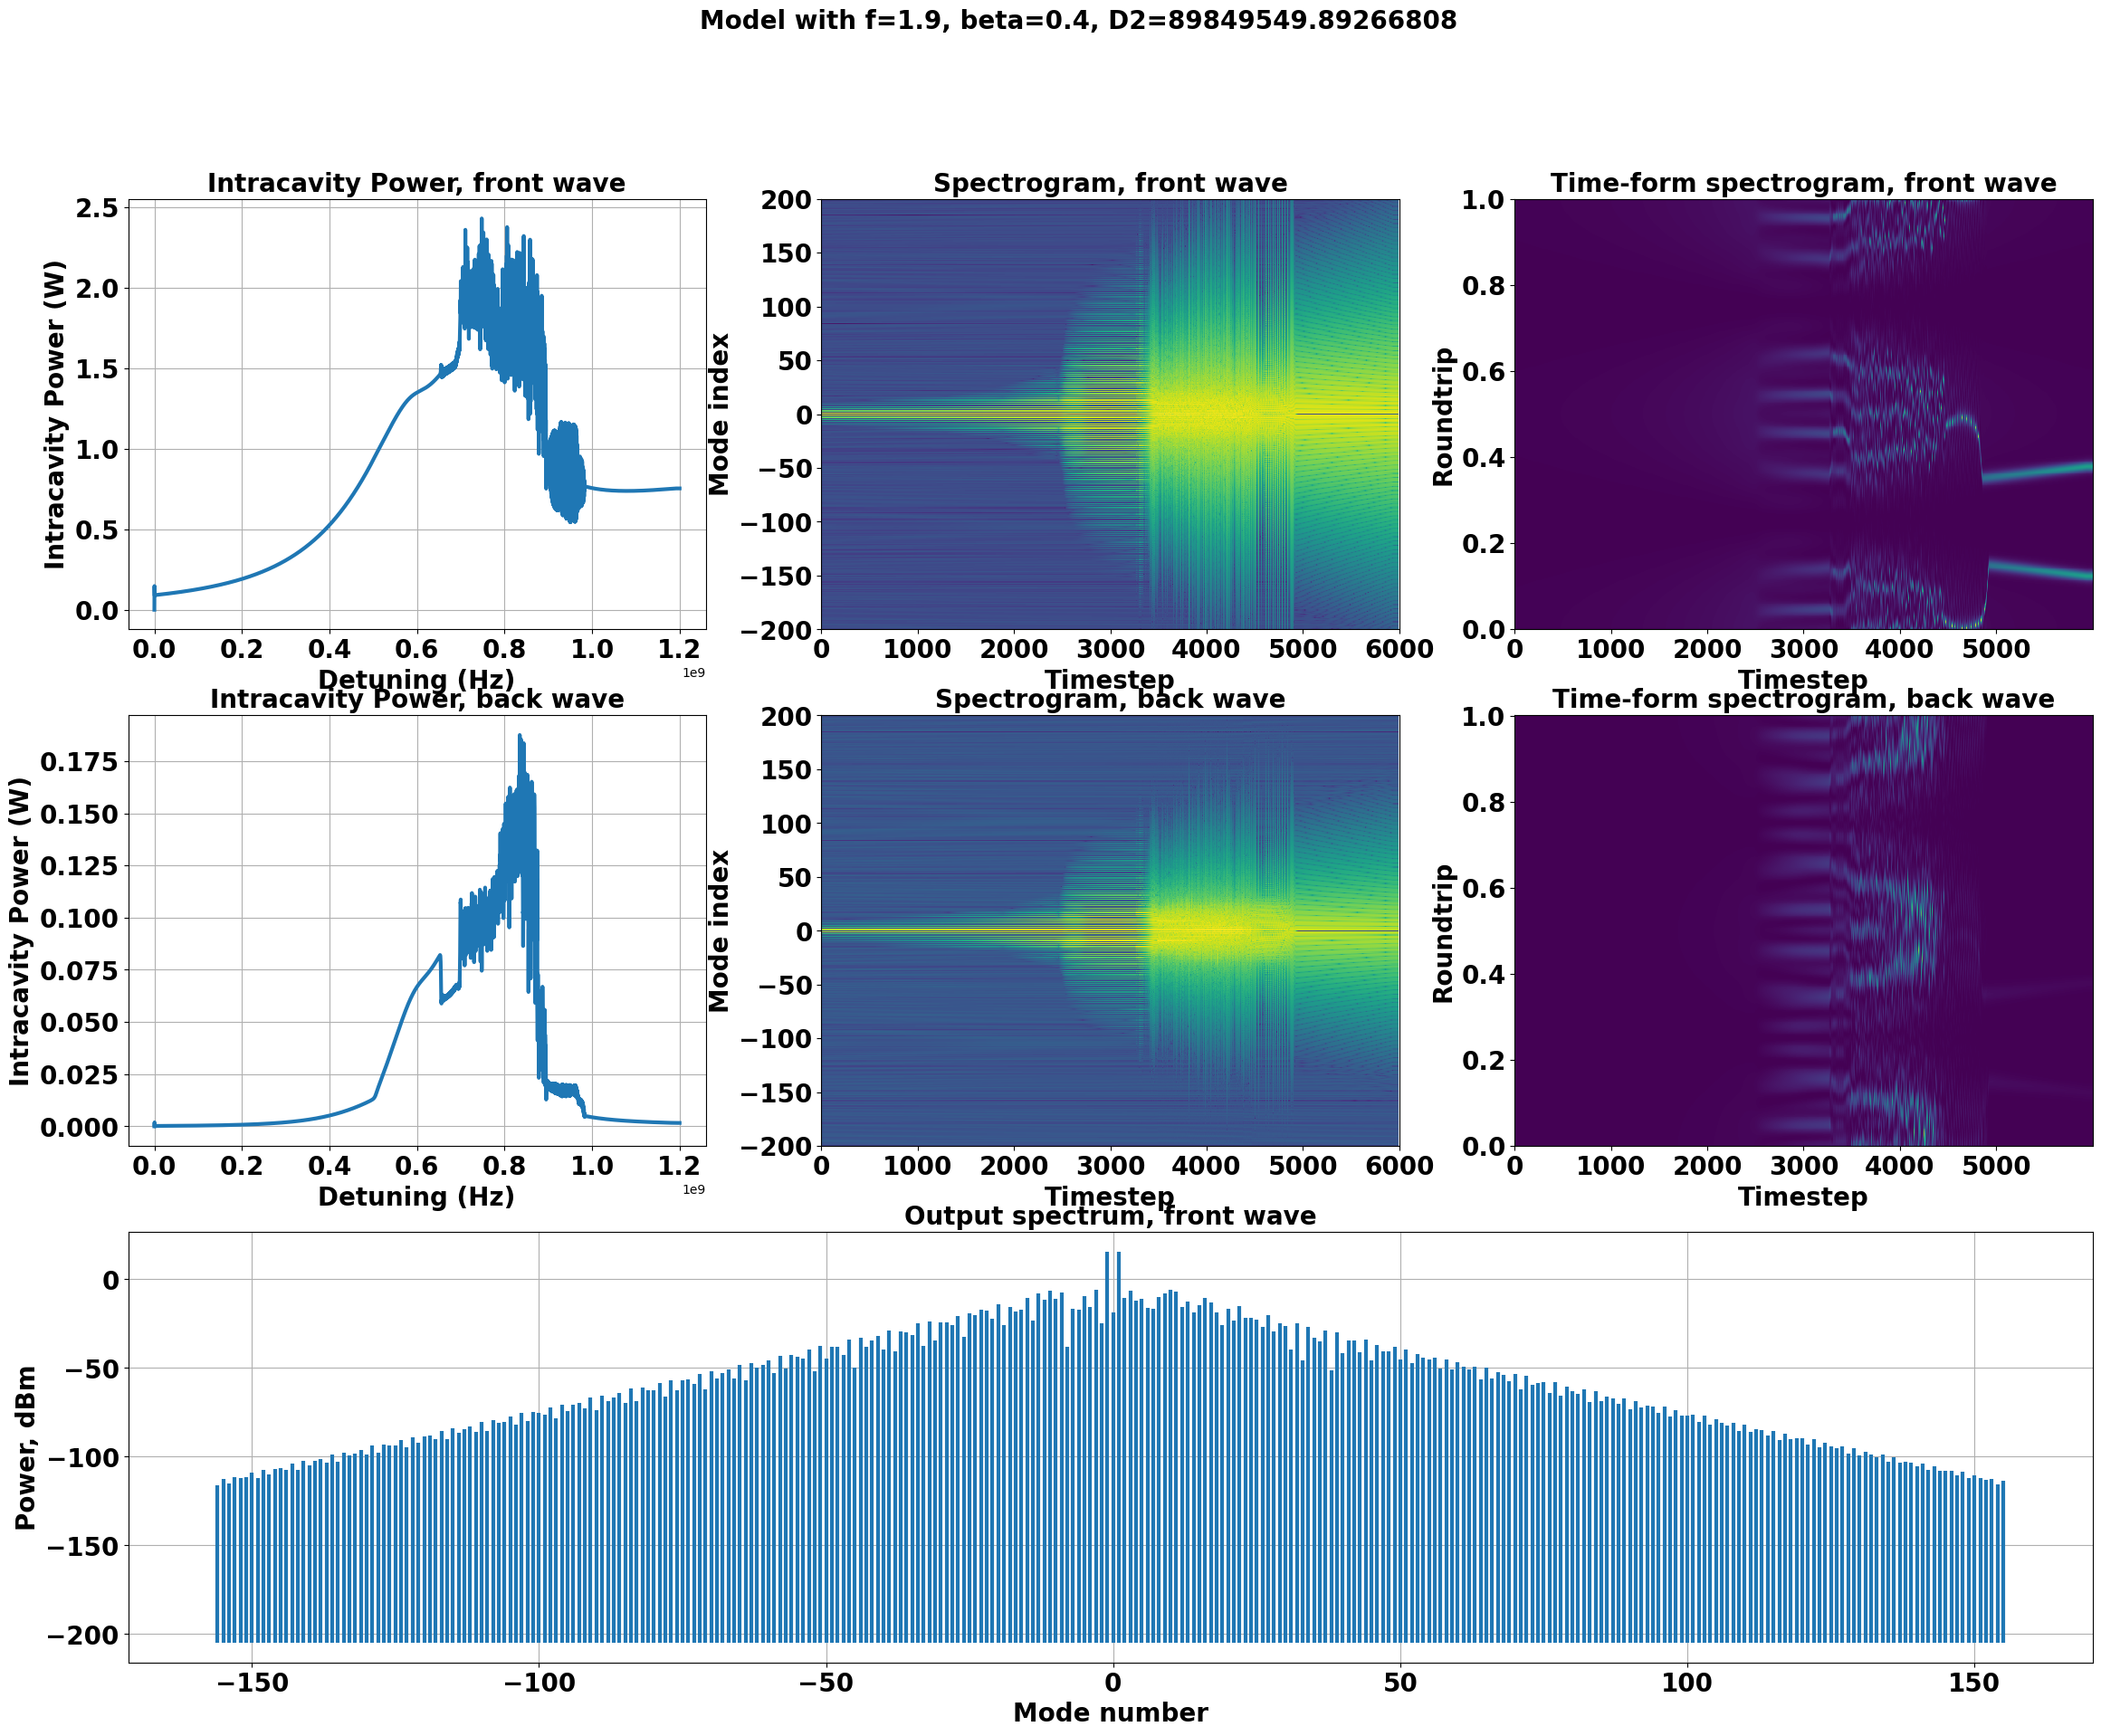

In [24]:
betas = [0.1, 0.2, 0.3, 0.4]

for bet in betas:
    Pump=np.zeros(len(mu), dtype='complex128')
    w_0 = 2*pi*c/wavelength
    P_pl = f**2*((kappa_0+kappa_ex)**3*hbar*w_0)/(8*g0*kappa_ex)
    P_min = f**2*((kappa_0+kappa_ex)**3*hbar*w_0)/(8*g0*kappa_ex)
    Pump[n]=np.sqrt(P_pl)
    Pump[-n]=np.sqrt(P_min)
    beta = bet
    
    PhysicalParameters={'n0' : n0, 
    'n2' : n2, ### m^2/W|
    'FSR' : FSR, #Hz
    'n_pump' : n,
    'w0' : w0,
    'width' : width, #m
    'height' : height, #m
    'kappa_0': kappa_0, 
    'kappa_ex' : kappa_ex, #0.998**mu*25e6*2*np.pi, 
    'Dint' : Dint,
    'dzeta': dzeta*2*np.pi*FSR,
    'N_micro':N_micro,
    'attempt_num':attempt_num,
    'alpha': alpha,
    'beta': beta,
    'thermal_Kerr': r_theta,
    'thermal_time': k_theta}

    single_ring=Resonator(PhysicalParameters)
    data=[]
    n_iter=1
    probability=np.zeros(n_iter)


    j = 0

    data=single_ring.Propagate_SplitStep_dual_back(simulation_parameters, Pump, Seed=[0], dt=1e-3);
    
    sol1=data[1][:]
    sol3=data[3][:]
    n_arange=int(nn)
    detuning1_torch=data[4*j+2]
    detuning2_torch=data[4*j+3]
    i = 0
    n_arange=int(nn)
    coeff = single_ring.kappa_ex / FSR / 2 / np.pi 
    to_power = single_ring.kappa/2/single_ring.g0*FSR
    
    line_width = 3
    font_size = 20
    font_weight = 'bold'
    
    power_modes=np.abs(sol1)**2
    detunings=detuning(dOm1, dOm2, gamma, Leff, FSR, power_modes,  Dint, kappa_total, mu, alpha)

    pump_init = np.zeros_like(power_modes)
    pump_init[:, 0, -n] = P_min
    pump_init[:, 0, n] = P_pl
    coeff = single_ring.kappa_ex / FSR / 2 / np.pi 

    
    fig = plt.figure(figsize=(28,21))
    
    numb = 4000
    plt.subplot(3,1,3)
    for i in mu.astype(int)[100:-100]:
        power_min = np.min(10*np.log10(np.abs(np.sqrt(pump_init[numb][0]/hbar/single_ring.w0) - np.sqrt(coeff) * (sol1[numb][0]) * np.sqrt(to_power))**2 * hbar * single_ring.w0 * 1e3))
        power_max = 10*np.log10(np.abs(np.sqrt(pump_init[numb][0][i]/hbar/single_ring.w0) - np.sqrt(coeff) * (sol1[numb][0][i]) * np.sqrt(to_power))**2 * hbar * single_ring.w0 * 1e3)
        plt.vlines(i, power_min, power_max, linewidth = line_width)
    plt.title('Output spectrum, front wave', fontsize = font_size, fontweight = font_weight)
    plt.xlabel('Mode number', fontsize = font_size, fontweight = font_weight)
    plt.ylabel('Power, dBm', fontsize = font_size, fontweight = font_weight)
    plt.grid()
    plt.xticks(fontsize = font_size, fontweight = font_weight)
    plt.yticks(fontsize = font_size, fontweight = font_weight)

    
    plt.subplot(3,3,1)
    plt.xlabel('Detuning (Hz)', fontsize = font_size, fontweight = font_weight)
    plt.title('Intracavity Power, front wave', fontsize = font_size, fontweight = font_weight)
    plt.ylabel('Intracavity Power (W)', fontsize = font_size, fontweight = font_weight)
    plt.plot(np.arange(n_arange)/dzeta, (abs(data[1].T)**2).sum(axis=0)[0], linewidth = line_width)
    plt.grid()
    plt.xticks(fontsize = font_size, fontweight = font_weight)
    plt.yticks(fontsize = font_size, fontweight = font_weight)

    
    plt.subplot(3,3,4)
    plt.xlabel('Detuning (Hz)', fontsize = font_size, fontweight = font_weight)
    plt.title('Intracavity Power, back wave', fontsize = font_size, fontweight = font_weight)
    plt.ylabel('Intracavity Power (W)', fontsize = font_size, fontweight = font_weight)
    plt.plot(np.arange(n_arange)/dzeta, (abs(data[3].T)**2).sum(axis=0)[0], linewidth = line_width)
    plt.grid()
    plt.xticks(fontsize = font_size, fontweight = font_weight)
    plt.yticks(fontsize = font_size, fontweight = font_weight)
    
    
    
    
    power_modes=np.abs(sol1)**2
    detunings=detuning(dOm1, dOm2, gamma, Leff, FSR, power_modes,  Dint, kappa_total, mu, alpha)

    pump_init = np.zeros_like(power_modes)
    pump_init[:, 0, -n] = P_min
    pump_init[:, 0, n] = P_pl
    coeff = single_ring.kappa_ex / FSR / 2 / np.pi 

    plt.subplot(3,3,2)
    power_dBm = 10*np.log10((power_modes[1:,0,np.fft.fftshift(mu).astype(int)]*single_ring.kappa/2/single_ring.g0*hbar*single_ring.w0*FSR))
    plt.pcolormesh(np.arange(np.shape(power_dBm)[0]), mu, np.fft.fftshift(power_dBm.T, axes = 0))#, vmin = 0)
    plt.ylim(-200,200)
    plt.xlim(0, nn)
    plt.title('Spectrogram, front wave', fontsize = font_size, fontweight = font_weight)
    plt.xlabel('Timestep', fontsize = font_size, fontweight = font_weight)
    plt.ylabel('Mode index', fontsize = font_size, fontweight = font_weight)
    plt.xticks(fontsize = font_size, fontweight = font_weight)
    plt.yticks(fontsize = font_size, fontweight = font_weight)
    
    
    
    power_modes=np.abs(sol3)**2
    detunings=detuning(dOm1, dOm2, gamma, Leff, FSR, power_modes,  Dint, kappa_total, mu, alpha)

    pump_init = np.zeros_like(power_modes)
    pump_init[:, 0, -n] = P_min
    pump_init[:, 0, n] = P_pl
    coeff = single_ring.kappa_ex / FSR / 2 / np.pi 


    plt.subplot(3,3,5)
    power_dBm = 10*np.log10((power_modes[1:,0,np.fft.fftshift(mu).astype(int)]*single_ring.kappa/2/single_ring.g0*hbar*single_ring.w0*FSR))
    plt.pcolormesh(np.arange(np.shape(power_dBm)[0]), mu, np.fft.fftshift(power_dBm.T, axes = 0))
    plt.ylim(-200,200)
    plt.xlim(0, nn)
    plt.title('Spectrogram, back wave', fontsize = font_size, fontweight = font_weight)
    plt.xlabel('Timestep', fontsize = font_size, fontweight = font_weight)
    plt.ylabel('Mode index', fontsize = font_size, fontweight = font_weight)
    plt.xticks(fontsize = font_size, fontweight = font_weight)
    plt.yticks(fontsize = font_size, fontweight = font_weight)
    
    
    plt.subplot(3,3,3)
    plt.pcolormesh(np.arange(nn), np.linspace(0, 1, 512), (np.abs(np.fft.ifft(sol1).T)**2)[:,0,:])
    plt.title('Time-form spectrogram, front wave', fontsize = font_size, fontweight = font_weight)
    plt.xlabel('Timestep', fontsize = font_size, fontweight = font_weight)
    plt.ylabel('Roundtrip', fontsize = font_size, fontweight = font_weight)
    plt.xticks(fontsize = font_size, fontweight = font_weight)
    plt.yticks(fontsize = font_size, fontweight = font_weight)
    
    plt.subplot(3,3,6)
    plt.pcolormesh(np.arange(nn), np.linspace(0, 1, 512), (np.abs(np.fft.ifft(sol3).T)**2)[:,0,:])
    plt.title('Time-form spectrogram, back wave', fontsize = font_size, fontweight = font_weight)
    plt.xlabel('Timestep', fontsize = font_size, fontweight = font_weight)
    plt.ylabel('Roundtrip', fontsize = font_size, fontweight = font_weight)
    plt.xticks(fontsize = font_size, fontweight = font_weight)
    plt.yticks(fontsize = font_size, fontweight = font_weight)
    
    plt.suptitle("Model with f=" + str(f) + ", beta=" + str(beta) + ", D2=" + str(D2), fontweight = font_weight, fontsize = font_size)
    plt.savefig("Model with f=" + str(f) + ", beta=" + str(beta) + ", D2=" + str(D2) +'.png')#, dpi = 300)
    plt.show()
    np.save("Model with f=" + str(f) + ", beta=" + str(beta) + ", D2=" + str(D2) + '.npy', data )